# Week 2 ‒ 모두의 주차장 데이터를 이용해서 이용자별 향후 이용 건수 예측하기

## 문제 정의
- 목표 : 이용자 별 결제 이력을 바탕으로 향후 이용 건수를 예측하여 마케팅, 영업 등의 의사 결정 과정에 활용
- 예측 과제 : 이용자 별 한 향후 한 달간 이용 건수를 예측하는 Regression 문제 (평가 메트릭 : MSE, MAE)
- 데이터 : 2020.01.01 ~ 2020.12.31 기간에 대한 유저가입정보(유저ID, 가입일), 소비행동정보(상품ID, 점포주소, 결제일, 결제건수), 외부정보(서울시 교통량 데이터, 기상 데이터)

## 주어진 데이터의 컬럼 정보를 활용한 초기 가설 수립
- 가입일 : 가입한지 오래된 유저일수록 앱 사용이 익숙해서 서비스를 더 빈번하게 이용할 것이다.
- 상품/결제ID : 티켓(goods_type) 혹은 결제타입(d_type)별로 유저가 느끼는 만족도가 달라서 어떤 티켓을 주로 사용하는 유저인지에 따라 서비스 이용 빈도가 다를 것이다.
- 점포주소 : 주차장 위치, 특성에 따라 유저가 느끼는 만족도가 달라서 어느 곳의 주차장을 주로 이용하는 유저인지에 따라 서비스 이용 빈도가 다를 것이다.
- 결제일 : 주말보다 주중 결제 건이 많은 유저들은 업무와 관련된 주차 수요가 있어서 서비스를 더 빈번하게 이용할 것이다.
- 최고기온 : 너무 덥거나 추운 날일수록 더 편리하게 주차하고 싶어하는 수요가 많을 것이다.
- 불쾌지수 : 불쾌지수가 높은 날일수록 더 편리하게 주차하고 싶어하는 수요가 많을 것이다.

 ➡️ <b>EDA를 통해 가설을 검증하고, 유의미한 변수를 추려내어 이용자별 이용 건수를 예측하는 모델링 진행

# 데이터셋 불러오기

In [335]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.gridspec import GridSpec
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

plt.rcParams['font.family'] = 'Malgun Gothic'  # (Windows 용) 한글 출력을 위한 글꼴 설정
#plt.rcParams['font.family'] = 'AppleGothic'  # (MAC, 리눅스 용)
plt.rcParams['axes.unicode_minus'] = False    # 문자 - (마이너스) 정상 출력을 위한 코드

In [336]:
# # 구글 colab 사용시
# from google.colab import drive
# drive.mount('/content/drive')

In [337]:
# cd /content/drive/MyDrive/Colab_Notebooks

In [338]:
# set seed
np.random.seed(42)

In [339]:
# 데이터셋 불러오기
df = pd.read_csv('./실전db.csv')
df

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR
...,...,...,...,...,...,...,...,...
879266,1830551,2020-12-31,BB,219886,B,2020-12-31,1,GN
879267,1830570,2020-12-31,BB,82433,B,2020-12-31,1,CY
879268,1830580,2020-12-31,AA,92020,B,2020-12-31,1,JRR
879269,1830589,2020-12-31,BB,92437,B,2020-12-31,1,J


In [340]:
# 컬럼명 소문자로 변환
df= df.rename(columns=str.lower)
df

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR
...,...,...,...,...,...,...,...,...
879266,1830551,2020-12-31,BB,219886,B,2020-12-31,1,GN
879267,1830570,2020-12-31,BB,82433,B,2020-12-31,1,CY
879268,1830580,2020-12-31,AA,92020,B,2020-12-31,1,JRR
879269,1830589,2020-12-31,BB,92437,B,2020-12-31,1,J


In [341]:
# 컬럼별 dtype 수정
df[['join_date', 'date']] = df[['join_date', 'date']].apply(lambda X : pd.to_datetime(X))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879271 entries, 0 to 879270
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     879271 non-null  int64         
 1   join_date   879271 non-null  datetime64[ns]
 2   d_type      879271 non-null  object        
 3   store_id    879271 non-null  int64         
 4   goods_type  879271 non-null  object        
 5   date        879271 non-null  datetime64[ns]
 6   count       879271 non-null  int64         
 7   ad1         879271 non-null  object        
dtypes: datetime64[ns](2), int64(3), object(3)
memory usage: 53.7+ MB


In [342]:
# 데이터 요약
df.describe()

,user_id,store_id,count
count,8.792710e+05,879271.000000,879271.000000
mean,1.206566e+06,149599.960642,1.029079
std,4.206529e+05,68898.035318,0.512428
min,2.240000e+02,4.000000,1.000000
25%,9.005760e+05,92437.000000,1.000000
50%,1.321440e+06,173059.000000,1.000000
75%,1.542416e+06,220661.000000,1.000000
max,1.830598e+06,231465.000000,61.000000


In [343]:
df.describe(include = 'O')

,d_type,goods_type,ad1
count,879271,879271,879271
unique,3,4,85
top,AA,A,J
freq,493166,609790,179383


In [344]:
for col in df.columns:
    print(f"Column명: {col}")
    print(f"Unique값: {df[col].nunique()}")
    print()

Column명: user_id
Unique값: 165425

Column명: join_date
Unique값: 2352

Column명: d_type
Unique값: 3

Column명: store_id
Unique값: 1061

Column명: goods_type
Unique값: 4

Column명: date
Unique값: 366

Column명: count
Unique값: 56

Column명: ad1
Unique값: 85



In [345]:
for col in df[['d_type', 'goods_type', 'ad1']]:
    print(f"Column명: {col}")
    print(f"Unique값: {df[col].unique()}")
    print()

Column명: d_type
Unique값: ['AA' 'BB' 'CC']

Column명: goods_type
Unique값: ['A' 'C' 'B' 'D']

Column명: ad1
Unique값: ['GN' 'J' 'SC' 'MP' 'JRR' 'YD' 'GJ' 'YO' 'GSN' 'GBC' 'BF' 'DJ' '0' 'CD'
 'NO' 'CY' 'YC' 'SD' 'GD' 'GSW' 'DM' 'R' 'GB' 'GS' 'GHN' 'SB' 'IND' 'P'
 'GW' 'JR' 'GEJ' 'GGY' 'GKP' 'CAS' 'SG' 'BJG' 'BHW' 'GAY' 'GYI' 'CCA'
 'PJP' 'GGC' 'IYS' 'DB' 'GGM' 'GAS' 'WOID' 'DIV' 'AOI' 'COI' 'GPJ' 'SOI'
 'ABP' 'DOI' 'WF' 'BI' 'ZP' 'EP' 'Q' 'BO' 'ZE' 'RRR' 'QGI' 'DSO' 'SOD'
 'BOI' 'WT' 'BP' 'SP' 'CN' 'SJV' 'SDU' 'QH' 'BUD' 'CU' 'VU' 'WAE' 'NW'
 'DY' 'WH' 'GR' 'X' 'CVB' 'ADS' 'VO']



In [346]:
# 결측치 확인
df.isnull().sum()

user_id       0
join_date     0
d_type        0
store_id      0
goods_type    0
date          0
count         0
ad1           0
dtype: int64

# 필요 컬럼 추가

In [347]:
# 가입연월, 결제연월, 결제요일 컬럼 생성
df['join_yearmonth'] = df['join_date'].dt.strftime('%Y-%m')
df['pay_yearmonth'] = df['date'].dt.strftime('%Y-%m')
df['pay_dow'] = df['date'].dt.day_name()
df

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1,join_yearmonth,pay_yearmonth,pay_dow
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN,2014-01,2020-01,Wednesday
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J,2014-02,2020-01,Wednesday
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC,2014-11,2020-01,Wednesday
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP,2014-12,2020-01,Wednesday
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR,2014-12,2020-01,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...
879266,1830551,2020-12-31,BB,219886,B,2020-12-31,1,GN,2020-12,2020-12,Thursday
879267,1830570,2020-12-31,BB,82433,B,2020-12-31,1,CY,2020-12,2020-12,Thursday
879268,1830580,2020-12-31,AA,92020,B,2020-12-31,1,JRR,2020-12,2020-12,Thursday
879269,1830589,2020-12-31,BB,92437,B,2020-12-31,1,J,2020-12,2020-12,Thursday


# 컬럼별 EDA

## user_id(유저) 기준

### user_id = 999665

In [348]:
# user_id 999665의 연간 결제횟수 7919건
df_user = df.groupby('user_id')['count'].sum().reset_index().sort_values(by = 'count', ascending = False)
df_user

,user_id,count
44115,999665,7919
100781,1514190,284
16448,591610,245
90227,1467323,239
76230,1355841,235
...,...,...
45671,1023974,1
110166,1551355,1
45674,1024027,1
45676,1024047,1


In [349]:
# 매일 사용내역이 여러건 조회됨. 직원 공용 아이디일 가능성이 있어보임
df[df['user_id']==999665]

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1,join_yearmonth,pay_yearmonth,pay_dow
372,999665,2018-12-16,CC,82399,A,2020-01-01,6,JRR,2018-12,2020-01,Wednesday
1527,999665,2018-12-16,CC,104988,A,2020-01-02,11,GN,2018-12,2020-01,Thursday
3121,999665,2018-12-16,CC,181832,A,2020-01-03,7,SC,2018-12,2020-01,Friday
5034,999665,2018-12-16,CC,109223,A,2020-01-04,28,MP,2018-12,2020-01,Saturday
6919,999665,2018-12-16,CC,104916,A,2020-01-05,14,GN,2018-12,2020-01,Sunday
...,...,...,...,...,...,...,...,...,...,...,...
867260,999665,2018-12-16,CC,2428,A,2020-12-27,17,CY,2018-12,2020-12,Sunday
868847,999665,2018-12-16,CC,109267,A,2020-12-28,24,J,2018-12,2020-12,Monday
871562,999665,2018-12-16,CC,90193,C,2020-12-29,23,GW,2018-12,2020-12,Tuesday
874317,999665,2018-12-16,CC,220797,D,2020-12-30,40,GS,2018-12,2020-12,Wednesday


In [350]:
# 이상치로 판단하여 제거하고 진행
df = df[df['user_id'] != 999665]
df

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1,join_yearmonth,pay_yearmonth,pay_dow
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN,2014-01,2020-01,Wednesday
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J,2014-02,2020-01,Wednesday
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC,2014-11,2020-01,Wednesday
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP,2014-12,2020-01,Wednesday
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR,2014-12,2020-01,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...
879266,1830551,2020-12-31,BB,219886,B,2020-12-31,1,GN,2020-12,2020-12,Thursday
879267,1830570,2020-12-31,BB,82433,B,2020-12-31,1,CY,2020-12,2020-12,Thursday
879268,1830580,2020-12-31,AA,92020,B,2020-12-31,1,JRR,2020-12,2020-12,Thursday
879269,1830589,2020-12-31,BB,92437,B,2020-12-31,1,J,2020-12,2020-12,Thursday


### count값 분포

In [351]:
# row별 최대, 최소 count값
print('최소값 : ' + str(df['count'].min()))
print('최대값 : ' + str(df['count'].max()))

최소값 : 1
최대값 : 23


<AxesSubplot:>

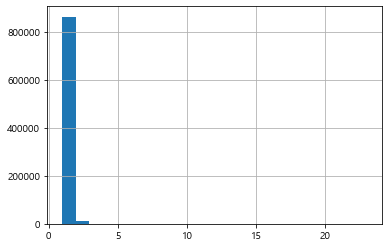

In [352]:
# row별 count값 분포 확인
df['count'].hist(bins = 23)

⚡<b>인사이트</b>⚡
- 'count' 컬럼은 같은 날짜, 같은 store에서 여러건을 이용한 데이터이므로 데이터 자체의 오류일 가능성도 있어 보임
- 1시간권을 여러장 나누어 구매했거나 기타 다른 사유로 정확하게 집계된 데이터일 가능성도 있으므로 별도의 전처리는 진행하지 않음
- 다만 유저가 한달에 얼마나 자주 서비스를 이용하는지 예측하는데 있어서는 오히려 예측 정확도를 떨어뜨릴 가능성이 있을 것으로 보임

### user_id별 서비스 이용횟수

In [353]:
# 유저별 서비스 이용횟수
df_user = df.groupby('user_id')['count'].sum().reset_index().sort_values(by = 'count', ascending = False)
df_user

,user_id,count
100780,1514190,284
16448,591610,245
90226,1467323,239
76229,1355841,235
62808,1224426,223
...,...,...
81384,1402020,1
81383,1402008,1
81382,1401999,1
81379,1401974,1


<AxesSubplot:>

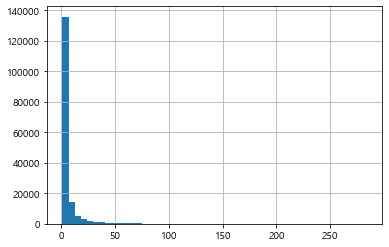

In [354]:
df_user['count'].hist(bins = 50)

In [355]:
# 전체 유저의 44.7%는 사용 이력이 1회
round(len(df_user.loc[df_user['count']==1, 'user_id'].to_list()) / df_user.shape[0] * 100,1)

44.7

⚡<b>인사이트</b>⚡
- 어떤 특성을 가진 유저가 서비스를 더 많이 이용하는지를 구분하고자 하는 문제이므로, 주어진 기간중 사용이력이 1회인 유저 정보는 제외한 데이터셋으로도 예측 모델을 돌려 성능을 비교할 필요가 있음

## join_date(가입일) 기준

### join_date = 1970-01-01

In [356]:
# 가입일이 1970-01-01인 데이터 1093건
df_join_date = df.groupby('join_date')['count'].agg(['count','sum']).reset_index()
df_join_date

,join_date,count,sum
0,1970-01-01,1093,1119
1,2013-12-16,2,2
2,2013-12-17,26,27
3,2013-12-18,1,1
4,2013-12-21,2,2
...,...,...,...
2347,2020-12-27,102,105
2348,2020-12-28,135,140
2349,2020-12-29,115,117
2350,2020-12-30,106,108


In [357]:
# user_id가 join_date 순서로 부여되었는지 확인
df_join_order = df.groupby('user_id')['join_date', 'count'].agg({'join_date' : 'min',
                                                                 'count' : 'sum'}).reset_index().sort_values(by = 'user_id')
df_join_order

<ipython-input-357-822f6a27cb88>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_join_order = df.groupby('user_id')['join_date', 'count'].agg({'join_date' : 'min',


,user_id,join_date,count
0,224,2013-12-16,2
1,232,2013-12-17,24
2,342,2013-12-17,1
3,565,2013-12-17,2
4,729,2013-12-18,1
...,...,...,...
165419,1830551,2020-12-31,1
165420,1830570,2020-12-31,1
165421,1830580,2020-12-31,1
165422,1830589,2020-12-31,1


In [358]:
# user_id는 join_date 순으로 부여되었음 (user_id가 작을수록 먼저 가입한 유저)
# join_date이 1970-01-01로 들어가있는 경우는 직전 유저 가입일로 임의 대체
check_1970 = 0
check_others = 0

for i in range(0, df_join_order.shape[0]):
    try:
        if (df_join_order.loc[i,'join_date'] - df_join_order.loc[i+1, 'join_date']).days > 0:
            if str(df_join_order.loc[i+1, 'join_date'] == '1970-01-01 00:00:00'):
                check_1970 += 1
                df_join_order.loc[i+1, 'join_date'] = df_join_order.loc[i,'join_date']
                
            else:
                check_others += 1
    except:
        pass

check_1970, check_others

(264, 0)

In [359]:
# 대체완료 확인
df_join_order[df_join_order['join_date']=='1970-01-01']

,user_id,join_date,count


In [360]:
df_join_order['join_yearmonth'] = df_join_order['join_date'].dt.strftime('%Y-%m')
df_join_order

,user_id,join_date,count,join_yearmonth
0,224,2013-12-16,2,2013-12
1,232,2013-12-17,24,2013-12
2,342,2013-12-17,1,2013-12
3,565,2013-12-17,2,2013-12
4,729,2013-12-18,1,2013-12
...,...,...,...,...
165419,1830551,2020-12-31,1,2020-12
165420,1830570,2020-12-31,1,2020-12
165421,1830580,2020-12-31,1,2020-12
165422,1830589,2020-12-31,1,2020-12


### join_yearmonth별 총이용건수 및 유저수

In [361]:
df_join_date = df_join_order.groupby('join_yearmonth')['user_id','count'].agg(
    {'user_id' : 'count', 'count' : 'sum'}).reset_index().sort_values(by = 'join_yearmonth').rename(
    columns ={'user_id' : 'user_count', 'count' : 'sum'})
df_join_date

<ipython-input-361-573e99b1211e>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_join_date = df_join_order.groupby('join_yearmonth')['user_id','count'].agg(


,join_yearmonth,user_count,sum
0,2013-12,9,38
1,2014-01,14,113
2,2014-02,9,33
3,2014-03,10,121
4,2014-04,1,5
...,...,...,...
80,2020-08,7128,30725
81,2020-09,6486,25714
82,2020-10,7583,21005
83,2020-11,7008,15660


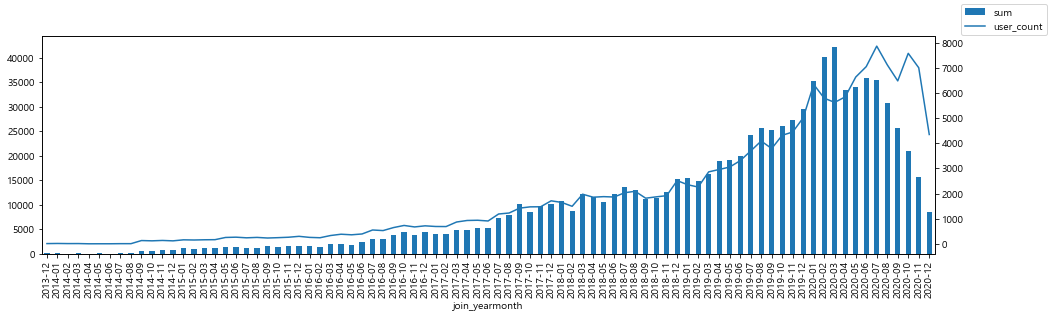

In [362]:
# 2013년 -> 2020년으로 갈수록 유저 수가 증가하여 이용건수가 증가한 것으로 보임
ax = df_join_date.plot(kind = 'bar', x='join_yearmonth', y='sum', legend=False, figsize=(16,4))
ax2 = ax.twinx()
df_join_date.plot(x='join_yearmonth', y='user_count', ax=ax2, legend=False)
ax.figure.legend()
plt.show()

### join_yearmonth별 인당 이용건수

In [363]:
# 가입연월별 2020년 인당 이용건수 비교
df_per_person = df_join_order.groupby('join_yearmonth')['count'].mean().reset_index()
df_per_person

,join_yearmonth,count
0,2013-12,4.222222
1,2014-01,8.071429
2,2014-02,3.666667
3,2014-03,12.100000
4,2014-04,5.000000
...,...,...
80,2020-08,4.310466
81,2020-09,3.964539
82,2020-10,2.770012
83,2020-11,2.234589


<AxesSubplot:xlabel='join_yearmonth', ylabel='count'>

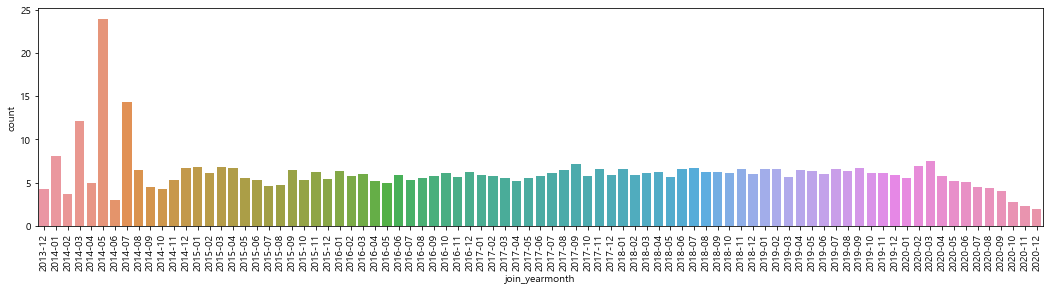

In [364]:
# 가입연월별 2020년 인당 이용건수는 5~10건 범위에서 대체로 비슷하게 나타남
# 2014년 가입자 중 heavy user들이 있는 것으로 보이나 전체적으로 가입연월에 따른 이용횟수의 차이는 없는 것으로 보임
plt.figure(figsize = (18,4))
plt.xticks(rotation = 90)
sns.barplot(x = df_per_person['join_yearmonth'], y = df_per_person['count'])

⚡<b>인사이트</b>⚡
- join_date는 유저의 서비스 이용횟수 예측에 중요한 정보가 아닌 것으로 보임

## date(사용일) 기준

### pay_yearmonth별 총이용건수 및 유저수

In [365]:
df_date = df.groupby('pay_yearmonth')['user_id', 'count'].agg({
    'user_id' : 'count', 'count' : 'sum'}).reset_index().sort_values(by = 'pay_yearmonth').rename(
    columns ={'user_id' : 'user_count', 'count' : 'sum'})
df_date

<ipython-input-365-8d8526dd66e5>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_date = df.groupby('pay_yearmonth')['user_id', 'count'].agg({


,pay_yearmonth,user_count,sum
0,2020-01,52885,53858
1,2020-02,55940,57019
2,2020-03,62111,63212
3,2020-04,64501,65636
4,2020-05,69925,71288
5,2020-06,75173,76639
6,2020-07,86230,87974
7,2020-08,78634,80231
8,2020-09,77906,79718
9,2020-10,87739,89742


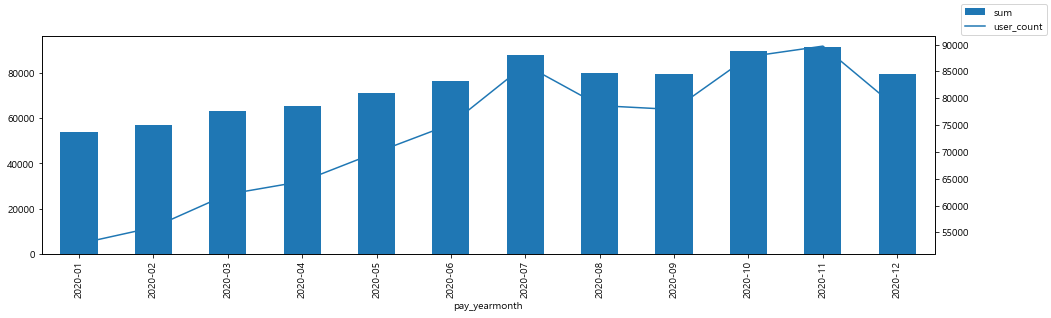

In [366]:
# 2020년 이용건수 분포
# 2020년에는 지속적으로 이용건수가 증가하는 추세에서 8,9,12월은 감소하였음
ax = df_date.plot(kind = 'bar', x='pay_yearmonth', y='sum', legend=False, figsize=(16,4))
ax2 = ax.twinx()
df_date.plot(x='pay_yearmonth', y='user_count', ax=ax2, legend=False)
ax.figure.legend()
plt.show()

### 요일별 이용건수

In [367]:
df_dow = df.groupby('pay_dow')['count'].sum().reset_index().sort_values(by = 'count', ascending = False)
df_dow

,pay_dow,count
0,Friday,140614
4,Thursday,136152
6,Wednesday,134931
2,Saturday,134483
5,Tuesday,133258
1,Monday,129460
3,Sunday,88022


<AxesSubplot:xlabel='pay_dow', ylabel='count'>

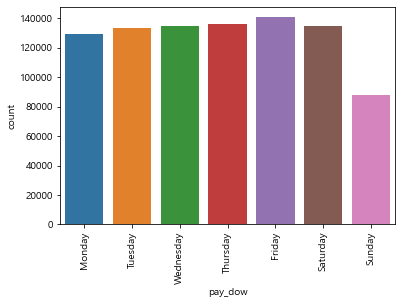

In [368]:
# 요일별 이용자수 : 목~금요일이 가장 많으며, 일요일이 가장 적음
plt.figure(figsize = (6,4))
plt.xticks(rotation = 90)
dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.barplot(x = df_dow['pay_dow'], y = df_dow['count'], order = dow_order)

⚡<b>인사이트</b>⚡
- 주어진 데이터셋이 1년치이므로 모델 예측에 월 정보를 활용하기는 어려우나, 요일 정보는 피쳐로 활용 가능할 것으로 보임

## store_id 기준

### store_id별 이용건수

In [369]:
# 총 1060개의 store_id
df_store_id = df.groupby('store_id')['count'].agg('sum').reset_index().sort_values(by = 'count',ascending = False)
df_store_id

,store_id,count
513,220557,17772
611,220893,17540
532,220655,16787
142,92437,16300
602,220848,16298
...,...,...
930,230196,1
926,230190,1
463,220018,1
922,228955,1


<AxesSubplot:>

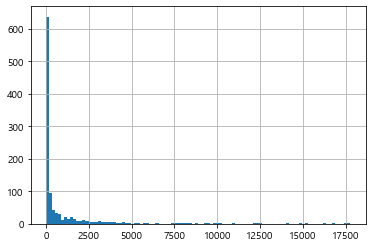

In [370]:
# store별 이용건수 분포 확인
df_store_id['count'].hist(bins = 100)

In [371]:
# 전체 store_id의 5.9%는 이용건수가 1건이며, 전체적으로 store_id별 이용건수의 편차가 크게 나타남
round(df_store_id[df_store_id['count'] == 1].shape[0] / df_store_id.shape[0] * 100, 2)

5.94

### user_id별 이용한 Store 개수

In [372]:
# 서비스 이용횟수가 높은 유저들은 같은 store를 이용하는 경우가 많은 것으로 보임
df_store_id_user = df.groupby(['store_id','user_id'])['count'].agg(['count', 'sum']).reset_index().sort_values(
    by = 'count', ascending = False)
df_store_id_user

,store_id,user_id,count,sum
146244,109557,1355841,235,235
146257,109557,1365069,222,222
238733,220655,1144500,213,213
180794,182296,909315,209,209
498,472,1201981,207,207
...,...,...,...,...
122727,105426,1424635,1,1
122730,105426,1430396,1,1
122731,105426,1431760,1,1
122732,105426,1433169,1,1


In [373]:
df_store_count = df_store_id_user.groupby('user_id')['store_id'].count().reset_index().sort_values(
    by = 'store_id', ascending = False).rename(columns = {'store_id' : 'store_count'})
df_store_count

,user_id,store_count
35969,883926,56
33141,843730,41
11830,502349,36
50635,1088030,35
44750,1008886,34
...,...,...
75599,1350095,1
75597,1350086,1
75596,1350084,1
75595,1350060,1


<AxesSubplot:>

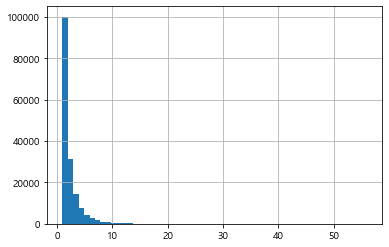

In [374]:
# 유저별 이용한 store 개수 분포 확인
df_store_count['store_count'].hist(bins = 56)

In [375]:
# 전체 유저의 60.5%는 1개 store만 이용하였음
round(df_store_count[df_store_count['store_count'] == 1].shape[0] / df_store_count.shape[0] * 100, 1)

60.5

<AxesSubplot:>

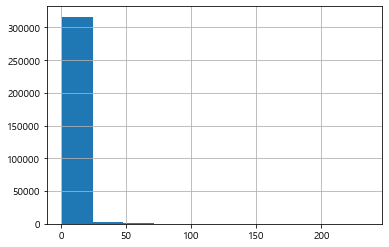

In [376]:
df_store_id_user['count'].hist()

⚡<b>인사이트</b>⚡
- 이용횟수가 많은 유저들은 같은 store 서비스를 이용하는 경향이 있는 것으로 보이며, 이는 주 생활 반경이 어느정도 정해져있는 이유도 있겠지만 해당 store의 편의성이 좋기 때문일 가능성도 있음
- store_id는 피쳐로 활용 가능할 것으로 보임 (지역 정보를 담고있는 ad1 컬럼과 비교하여 둘중 하나 사용 예정)

## dtype 기준

In [377]:
df_dtype = df.groupby('d_type')['count'].sum().reset_index()
df_dtype

,d_type,count
0,AA,503976
1,BB,391700
2,CC,1244


<AxesSubplot:xlabel='d_type', ylabel='count'>

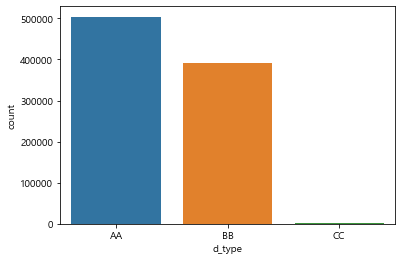

In [378]:
# AA 타입이 가장 높은 비율을 차지
plt.figure(figsize = (6,4))
sns.barplot(x = df_dtype['d_type'], y = df_dtype['count'])

⚡<b>인사이트</b>⚡
- 모두의주차장 서비스 이용 옵션들을 확인한 결과 d_type은 결제수단을 의미하는 컬럼일 것으로 추정<br>
AA: 카드결제<br>
BB: 네이버페이<br>
CC: 휴대폰결제<br>
- d_type은 피쳐로 활용 가능할 것으로 보임

## goods_type 기준

In [379]:
df_goods = df.groupby('goods_type')['count'].sum().reset_index()
df_goods

,goods_type,count
0,A,621745
1,B,120279
2,C,134641
3,D,20255


<AxesSubplot:xlabel='goods_type', ylabel='count'>

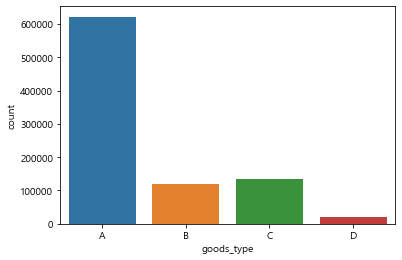

In [380]:
# A 타입이 가장 높은 비율을 차지
plt.figure(figsize = (6,4))
sns.barplot(x = df_goods['goods_type'], y = df_goods['count'])

⚡<b>인사이트</b>⚡
- 모두의주차장 서비스 이용 옵션들을 확인한 결과 goods_type은 티켓타입을 의미하는 컬럼일 것으로 추정
- 당일권, 3시간권, 2시간권, 1시간권 등의 다양한 옵션이 있고 평일과 휴일의 티켓이 구분되어 있으므로 A~D가 각각 어떤 티켓타입인지는 확정하기 어려움
- goods_type은 피쳐로 활용 가능할 것으로 보임

## ad1 기준

In [381]:
df_ad1 = df.groupby('ad1')['count'].sum().reset_index().sort_values(by = 'count', ascending = False)
df_ad1

,ad1,count
49,J,182743
39,GN,176880
51,JRR,129467
63,SC,77272
52,MP,68893
...,...,...
70,SP,3
71,VO,1
54,NW,1
41,GR,1


<AxesSubplot:xlabel='ad1', ylabel='count'>

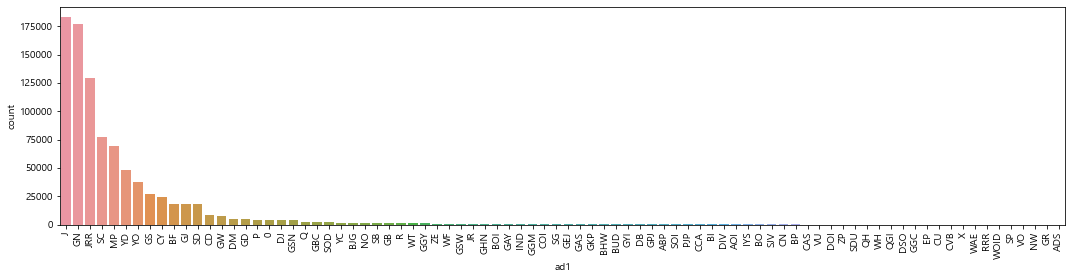

In [382]:
# J, GN이 전체 이용건수 기준 가장 높은 비율을 차지
plt.figure(figsize = (18,4))
plt.xticks(rotation = 90)
sns.barplot(x = df_ad1['ad1'], y = df_ad1['count'])

In [383]:
# 서비스 이용횟수가 높은 유저들은 같은 ad1에서 사용하는 경우가 많은 것으로 보임
df_ad1_user = df.groupby(['ad1','user_id'])['count'].agg(['count', 'sum']).reset_index().sort_values(by = 'count', ascending = False)
df_ad1_user

,ad1,user_id,count,sum
134874,JRR,591610,244,245
30107,GJ,1355841,235,235
30149,GJ,1365069,222,222
145445,JRR,1144500,213,213
112276,J,1407916,209,209
...,...,...,...,...
141362,JRR,943090,1,1
141363,JRR,943167,1,1
141364,JRR,943449,1,1
141366,JRR,943548,1,1


⚡<b>인사이트</b>⚡
- ad1은 주차장 위치에 대한 지역 표기일 것으로 추정됨
- 이용횟수가 많은 유저들은 같은 ad1에서 서비스를 이용하는 경향이 있는 것으로 보이며, 이는 주 생활 반경이 어느정도 정해져있는 이유도 있겠지만 해당 ad1의 주차장 개수, 편의성 등의 인프라가 좋기 때문일 가능성도 있음
- ad1은 피쳐로 활용 가능할 것으로 보임

# 심층 EDA


## top users
- 결제건수 상위 20명 유저를 대상으로 컬럼별 특징 살펴보기

In [384]:
df_user

,user_id,count
100780,1514190,284
16448,591610,245
90226,1467323,239
76229,1355841,235
62808,1224426,223
...,...,...
81384,1402020,1
81383,1402008,1
81382,1401999,1
81379,1401974,1


In [385]:
# 결제건수 상위 20명 유저
top_users_list = df_user['user_id'].head(20).unique()
top_users_list

array([1514190,  591610, 1467323, 1355841, 1224426, 1365069, 1407916,
       1284291, 1144500,  909315, 1504815, 1201981,  571472,  612237,
       1532535,  640247, 1303371, 1318771,  603013,  812843], dtype=int64)

In [386]:
top_users = df[df['user_id'].isin(top_users_list)].sort_values(by = 'user_id').reset_index()
top_users

,index,user_id,join_date,d_type,store_id,goods_type,date,count,ad1,join_yearmonth,pay_yearmonth,pay_dow
0,201736,571472,2017-08-03,AA,92437,B,2020-04-16,1,J,2017-08,2020-04,Thursday
1,396617,571472,2017-08-03,AA,92437,B,2020-07-07,1,J,2017-08,2020-07,Tuesday
2,47103,571472,2017-08-03,AA,92437,B,2020-01-29,1,J,2017-08,2020-01,Wednesday
3,399238,571472,2017-08-03,AA,92437,B,2020-07-08,1,J,2017-08,2020-07,Wednesday
4,401921,571472,2017-08-03,AA,92437,B,2020-07-09,1,J,2017-08,2020-07,Thursday
...,...,...,...,...,...,...,...,...,...,...,...,...
3831,374559,1532535,2020-03-31,BB,219913,A,2020-06-28,1,GN,2020-03,2020-06,Sunday
3832,691068,1532535,2020-03-31,BB,219913,A,2020-10-25,1,GN,2020-03,2020-10,Sunday
3833,688109,1532535,2020-03-31,BB,219913,A,2020-10-24,1,GN,2020-03,2020-10,Saturday
3834,360975,1532535,2020-03-31,BB,219913,B,2020-06-23,1,GN,2020-03,2020-06,Tuesday


In [387]:
# dtype : 각 유저당 하나의 dtype을 가짐
# 결제수단일 것으로 추정됨
for user in top_users_list:
  df_top = top_users.copy()
  d_type = df_top[df_top['user_id'] == user]['d_type'].unique()
  print(d_type)

['AA']
['AA']
['AA']
['AA']
['BB']
['AA']
['AA']
['AA']
['AA']
['BB']
['AA']
['BB']
['AA']
['AA']
['BB']
['BB']
['AA']
['AA']
['AA']
['AA']


In [388]:
# goods_type : 유저마다 다양한 goods_type 정보를 가짐
# 구매한 티켓 종류일 것으로 추정됨 (1일권, 3시간권 등)
for user in top_users_list:
  df_top = top_users.copy()
  inputs = df_top[df_top['user_id'] == user]['goods_type'].unique()
  print(inputs)

['A' 'B' 'C']
['A' 'C']
['B' 'A']
['A']
['A' 'B']
['A']
['A' 'B' 'D' 'C']
['A' 'B' 'C']
['A']
['A']
['A']
['A']
['B' 'A' 'C']
['A']
['A' 'B']
['A' 'C']
['A' 'D']
['A' 'D']
['A' 'B']
['C' 'A']


In [389]:
# ad1 : 유저마다 다양한 ad1 정보를 가짐
# 지역 분류일 것으로 추정됨
for user in top_users_list:
  df_top = top_users.copy()
  inputs = df_top[df_top['user_id'] == user]['ad1'].unique()
  print(inputs)

['GN' 'GS']
['JRR']
['JRR']
['GJ']
['J' 'YO']
['GJ']
['J' 'JRR']
['GJ' 'MP' 'JRR']
['JRR']
['SC']
['GN']
['GN']
['J' 'JRR' 'SD']
['MP']
['GN']
['CY']
['JRR']
['CY']
['JRR']
['GN' 'J']


## top stores
- 결제건수 상위 20개 store 대상으로 컬럼별 특징 살펴보기

In [390]:
# 결제건수 상위 20개 store
top_stores_list = df.groupby('store_id')['count'].sum().sort_values(ascending = False).reset_index().head(20)['store_id'].tolist()
top_stores_list

[220557,
 220893,
 220655,
 92437,
 220848,
 105033,
 91853,
 1109,
 82400,
 109037,
 173268,
 220836,
 220745,
 182296,
 220897,
 221045,
 28018,
 109557,
 90542,
 109400]

In [391]:
top_stores = df[df['store_id'].isin(top_stores_list)].sort_values(by = 'store_id').reset_index()
top_stores

,index,user_id,join_date,d_type,store_id,goods_type,date,count,ad1,join_yearmonth,pay_yearmonth,pay_dow
0,111088,1362090,2019-10-22,AA,1109,A,2020-03-02,1,JRR,2019-10,2020-03,Monday
1,789688,1537966,2020-04-08,AA,1109,A,2020-11-26,1,JRR,2020-04,2020-11,Thursday
2,146865,1071619,2019-02-20,BB,1109,A,2020-03-20,1,JRR,2019-02,2020-03,Friday
3,146867,1071768,2019-02-20,AA,1109,A,2020-03-20,1,JRR,2019-02,2020-03,Friday
4,789703,1541986,2020-04-14,AA,1109,A,2020-11-26,1,JRR,2020-04,2020-11,Thursday
...,...,...,...,...,...,...,...,...,...,...,...,...
246444,851642,1697046,2020-09-20,AA,221045,A,2020-12-20,1,GN,2020-09,2020-12,Sunday
246445,417396,1570996,2020-05-16,AA,221045,A,2020-07-14,1,GN,2020-05,2020-07,Tuesday
246446,277348,1434158,2019-12-17,AA,221045,A,2020-05-20,1,GN,2019-12,2020-05,Wednesday
246447,779441,485337,2017-03-21,AA,221045,B,2020-11-23,1,GN,2017-03,2020-11,Monday


In [392]:
# dtype : 스토어마다 다양한 d_type 정보를 가짐
for store in top_stores_list:
  df_top = top_stores.copy()
  d_type = df_top[df_top['store_id'] == store]['d_type'].unique()
  print(d_type)

['AA' 'BB' 'CC']
['BB' 'AA' 'CC']
['AA' 'BB' 'CC']
['AA' 'BB' 'CC']
['AA' 'BB' 'CC']
['BB' 'AA' 'CC']
['AA' 'BB' 'CC']
['AA' 'BB' 'CC']
['AA' 'BB' 'CC']
['AA' 'BB' 'CC']
['AA' 'BB' 'CC']
['BB' 'AA' 'CC']
['AA' 'BB' 'CC']
['AA' 'BB' 'CC']
['BB' 'AA' 'CC']
['AA' 'BB' 'CC']
['BB' 'AA' 'CC']
['AA' 'BB' 'CC']
['AA' 'BB' 'CC']
['AA' 'BB']


In [393]:
# goods_type : 스토어마다 다양한 goods_type 정보를 가짐
for store in top_stores_list:
  df_top = top_stores.copy()
  goods_type = df_top[df_top['store_id'] == store]['goods_type'].unique()
  print(goods_type)

['A' 'D']
['B' 'A' 'C']
['A' 'B']
['A' 'B' 'C']
['C' 'B']
['A' 'B']
['A' 'D' 'B']
['A' 'D']
['B' 'A']
['A' 'B' 'D']
['A' 'D' 'B']
['A' 'B']
['A' 'B']
['A' 'B']
['B' 'A']
['A' 'B']
['C' 'B']
['A' 'B']
['A' 'B' 'D']
['C' 'A' 'B']


In [394]:
# ad1 : 각 스토어당 하나의 ad1 정보를 가짐
for store in top_stores_list:
  df_top = top_stores.copy()
  ad1 = df_top[df_top['store_id'] == store]['ad1'].unique()
  print(ad1)

['YO']
['J']
['JRR']
['J']
['GN']
['SC']
['YD']
['JRR']
['JRR']
['J']
['J']
['JRR']
['SD']
['SC']
['J']
['GN']
['JRR']
['GJ']
['GN']
['J']


⚡<b>인사이트</b>⚡
- 유저마다 하나의 d_type이 매칭되고, 스토어마다 하나의 ad1이 매칭됨
- d_type은 결제수단, ad1은 지역일 것이라는 가설 확인

# 외부 데이터 활용

## 기상 데이터

In [395]:
# 기상정보 데이터셋 불러오기
climate = pd.read_csv('서울시_기상데이터.csv', encoding = 'cp949')
climate

,지점,일시,기온,강수량,풍속,습도,일조시간,적설량,지면온도,지중온도
0,108,2020-01-01 1:00,-5.9,NaN,1.7,40,NaN,NaN,-2.4,3.2
1,108,2020-01-01 2:00,-5.7,NaN,0.1,42,NaN,NaN,-2.4,3.1
2,108,2020-01-01 3:00,-5.6,0.0,0.0,46,NaN,NaN,-2.7,3.1
3,108,2020-01-01 4:00,-5.4,NaN,0.0,50,NaN,NaN,-2.5,3.0
4,108,2020-01-01 5:00,-5.2,NaN,0.0,55,NaN,NaN,-2.2,3.0
...,...,...,...,...,...,...,...,...,...,...
8755,108,2020-12-30 20:00,-11.8,NaN,4.8,54,NaN,NaN,-6.5,2.2
8756,108,2020-12-30 21:00,-12.4,NaN,3.2,58,NaN,NaN,-6.9,2.2
8757,108,2020-12-30 22:00,-12.7,NaN,2.8,56,NaN,NaN,-7.1,2.1
8758,108,2020-12-30 23:00,-12.9,NaN,2.2,54,NaN,NaN,-7.3,2.1


In [396]:
climate.describe()

,지점,기온,강수량,풍속,습도,일조시간,적설량,지면온도,지중온도
count,8760.0,8759.000000,1059.000000,8760.000000,8760.000000,4791.000000,208.000000,8752.000000,8748.000000
mean,108.0,13.328782,1.559112,2.374452,63.290297,0.471238,1.368750,14.603016,14.787517
std,0.0,10.015004,3.876191,1.198269,20.059407,0.445876,1.040408,12.262018,8.509368
min,108.0,-12.900000,0.000000,0.000000,11.000000,0.000000,0.000000,-7.800000,1.500000
25%,108.0,5.000000,0.000000,1.500000,48.000000,0.000000,0.700000,3.400000,6.200000
50%,108.0,13.900000,0.200000,2.200000,64.000000,0.400000,1.000000,14.700000,14.900000
75%,108.0,22.200000,1.300000,3.100000,80.000000,1.000000,1.800000,23.700000,23.400000
max,108.0,35.200000,42.100000,8.000000,100.000000,1.000000,5.500000,58.700000,28.200000


array([[<AxesSubplot:title={'center':'지점'}>,
        <AxesSubplot:title={'center':'기온'}>,
        <AxesSubplot:title={'center':'강수량'}>],
       [<AxesSubplot:title={'center':'풍속'}>,
        <AxesSubplot:title={'center':'습도'}>,
        <AxesSubplot:title={'center':'일조시간'}>],
       [<AxesSubplot:title={'center':'적설량'}>,
        <AxesSubplot:title={'center':'지면온도'}>,
        <AxesSubplot:title={'center':'지중온도'}>]], dtype=object)

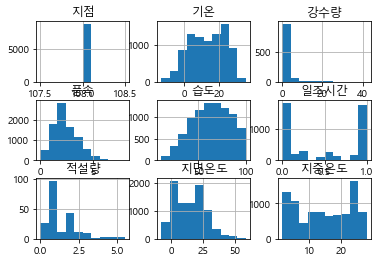

In [397]:
climate.hist()

In [398]:
climate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   지점      8760 non-null   int64  
 1   일시      8760 non-null   object 
 2   기온      8759 non-null   float64
 3   강수량     1059 non-null   float64
 4   풍속      8760 non-null   float64
 5   습도      8760 non-null   int64  
 6   일조시간    4791 non-null   float64
 7   적설량     208 non-null    float64
 8   지면온도    8752 non-null   float64
 9   지중온도    8748 non-null   float64
dtypes: float64(7), int64(2), object(1)
memory usage: 684.5+ KB


In [399]:
# 날짜, 불쾌지수 컬럼 생성
climate['날짜'] = climate['일시'].apply(lambda x : x[:10]).apply(lambda x : pd.to_datetime(x))
climate['불쾌지수'] = 9/5*climate['기온']-0.55*(1-climate['습도']/100)*(9/5*climate['기온']-26)+32
climate

,지점,일시,기온,강수량,풍속,습도,일조시간,적설량,지면온도,지중온도,날짜,불쾌지수
0,108,2020-01-01 1:00,-5.9,NaN,1.7,40,NaN,NaN,-2.4,3.2,2020-01-01,33.46460
1,108,2020-01-01 2:00,-5.7,NaN,0.1,42,NaN,NaN,-2.4,3.1,2020-01-01,33.30694
2,108,2020-01-01 3:00,-5.6,0.0,0.0,46,NaN,NaN,-2.7,3.1,2020-01-01,32.63576
3,108,2020-01-01 4:00,-5.4,NaN,0.0,50,NaN,NaN,-2.5,3.0,2020-01-01,32.10300
4,108,2020-01-01 5:00,-5.2,NaN,0.0,55,NaN,NaN,-2.2,3.0,2020-01-01,31.39160
...,...,...,...,...,...,...,...,...,...,...,...,...
8755,108,2020-12-30 20:00,-11.8,NaN,4.8,54,NaN,NaN,-6.5,2.2,2020-12-30,22.71172
8756,108,2020-12-30 21:00,-12.4,NaN,3.2,58,NaN,NaN,-6.9,2.2,2020-12-30,20.84192
8757,108,2020-12-30 22:00,-12.7,NaN,2.8,56,NaN,NaN,-7.1,2.1,2020-12-30,20.96412
8758,108,2020-12-30 23:00,-12.9,NaN,2.2,54,NaN,NaN,-7.3,2.1,2020-12-30,21.23266


In [400]:
# 날짜별 최고기온, 평균강수량, 평균적설량, 최대습도 구하기
# 극단적인 날씨 상황이 있는 날에 서비스 이용자 수가 더 많아질 것이라고 가정
# 최저기온이 관측되는 새벽보다는 최고기온이 관측되는 낮시간의 이용이 많을 것이므로 최저기온이 아닌 최고기온을 기온관련 변수로 사용
climate_grouped = climate.groupby('날짜')['기온','강수량','적설량','불쾌지수'].agg(
    {'기온' : 'max', '강수량' : ['sum', 'count'], '적설량' : ['sum', 'count'], '불쾌지수' : 'max'}).reset_index()
climate_grouped.columns = ['date', 'temp_max', 'rain_sum', 'rain_count', 'snow_sum', 'snow_count', 'discomfort_max']
climate_grouped

<ipython-input-400-e01227096b26>:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  climate_grouped = climate.groupby('날짜')['기온','강수량','적설량','불쾌지수'].agg(


,date,temp_max,rain_sum,rain_count,snow_sum,snow_count,discomfort_max
0,2020-01-01,0.3,0.1,4,0.0,1,37.86114
1,2020-01-02,3.8,0.0,0,0.0,0,43.26596
2,2020-01-03,4.3,0.0,0,0.0,0,46.77010
3,2020-01-04,6.1,0.0,0,0.0,0,48.51487
4,2020-01-05,6.5,0.0,0,0.0,0,49.20550
...,...,...,...,...,...,...,...
361,2020-12-27,9.9,0.0,1,0.0,0,52.11449
362,2020-12-28,11.0,1.3,2,0.0,0,53.50500
363,2020-12-29,4.2,0.2,3,0.0,0,42.19692
364,2020-12-30,-6.2,0.0,0,0.0,0,30.44586


In [401]:
# 시간당 rain, snow 계산
climate_grouped['rain_hourly'] = round(climate_grouped['rain_sum'] / climate_grouped['rain_count'], 1)
climate_grouped['snow_hourly'] = round(climate_grouped['snow_sum'] / climate_grouped['snow_count'], 1)
climate_grouped

,date,temp_max,rain_sum,rain_count,snow_sum,snow_count,discomfort_max,rain_hourly,snow_hourly
0,2020-01-01,0.3,0.1,4,0.0,1,37.86114,0.0,0.0
1,2020-01-02,3.8,0.0,0,0.0,0,43.26596,NaN,NaN
2,2020-01-03,4.3,0.0,0,0.0,0,46.77010,NaN,NaN
3,2020-01-04,6.1,0.0,0,0.0,0,48.51487,NaN,NaN
4,2020-01-05,6.5,0.0,0,0.0,0,49.20550,NaN,NaN
...,...,...,...,...,...,...,...,...,...
361,2020-12-27,9.9,0.0,1,0.0,0,52.11449,0.0,NaN
362,2020-12-28,11.0,1.3,2,0.0,0,53.50500,0.6,NaN
363,2020-12-29,4.2,0.2,3,0.0,0,42.19692,0.1,NaN
364,2020-12-30,-6.2,0.0,0,0.0,0,30.44586,NaN,NaN


In [402]:
# 일 최대기온이 33도 이상이거나 0도 이하인 경우, 불쾌지수 80 이상인 경우,
# 시간당 강수량 10 이상이거나 적설량 1 이상인 경우 ext_weather에 표시

climate_grouped.loc[climate_grouped['temp_max'] >= 33, 'ext_weather'] = 1
climate_grouped.loc[climate_grouped['temp_max'] < 0, 'ext_weather'] = 1
climate_grouped.loc[climate_grouped['discomfort_max'] >= 80, 'ext_weather'] = 1
climate_grouped.loc[climate_grouped['rain_hourly'] >= 10, 'ext_weather'] = 1
climate_grouped.loc[climate_grouped['snow_hourly'] >= 1, 'ext_weather'] = 1
climate_grouped

,date,temp_max,rain_sum,rain_count,snow_sum,snow_count,discomfort_max,rain_hourly,snow_hourly,ext_weather
0,2020-01-01,0.3,0.1,4,0.0,1,37.86114,0.0,0.0,NaN
1,2020-01-02,3.8,0.0,0,0.0,0,43.26596,NaN,NaN,NaN
2,2020-01-03,4.3,0.0,0,0.0,0,46.77010,NaN,NaN,NaN
3,2020-01-04,6.1,0.0,0,0.0,0,48.51487,NaN,NaN,NaN
4,2020-01-05,6.5,0.0,0,0.0,0,49.20550,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
361,2020-12-27,9.9,0.0,1,0.0,0,52.11449,0.0,NaN,NaN
362,2020-12-28,11.0,1.3,2,0.0,0,53.50500,0.6,NaN,NaN
363,2020-12-29,4.2,0.2,3,0.0,0,42.19692,0.1,NaN,NaN
364,2020-12-30,-6.2,0.0,0,0.0,0,30.44586,NaN,NaN,1.0


In [403]:
# ext_weather에 해당하지 않는 날은 0으로 표시
climate_grouped.loc[climate_grouped['ext_weather'].isnull(), 'ext_weather'] = 0
climate_grouped

,date,temp_max,rain_sum,rain_count,snow_sum,snow_count,discomfort_max,rain_hourly,snow_hourly,ext_weather
0,2020-01-01,0.3,0.1,4,0.0,1,37.86114,0.0,0.0,0.0
1,2020-01-02,3.8,0.0,0,0.0,0,43.26596,NaN,NaN,0.0
2,2020-01-03,4.3,0.0,0,0.0,0,46.77010,NaN,NaN,0.0
3,2020-01-04,6.1,0.0,0,0.0,0,48.51487,NaN,NaN,0.0
4,2020-01-05,6.5,0.0,0,0.0,0,49.20550,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...
361,2020-12-27,9.9,0.0,1,0.0,0,52.11449,0.0,NaN,0.0
362,2020-12-28,11.0,1.3,2,0.0,0,53.50500,0.6,NaN,0.0
363,2020-12-29,4.2,0.2,3,0.0,0,42.19692,0.1,NaN,0.0
364,2020-12-30,-6.2,0.0,0,0.0,0,30.44586,NaN,NaN,1.0


<AxesSubplot:>

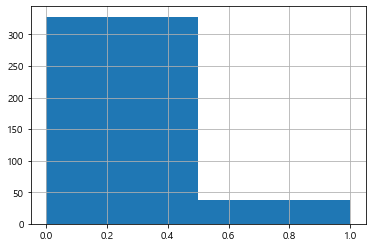

In [404]:
# ext_weather 분포 확인
climate_grouped['ext_weather'].hist(bins = 2)

In [405]:
df_temp = df.groupby('date')['count'].sum().reset_index()
df_temp

,date,count
0,2020-01-01,929
1,2020-01-02,1507
2,2020-01-03,1751
3,2020-01-04,2217
4,2020-01-05,1517
...,...,...
361,2020-12-27,1292
362,2020-12-28,2773
363,2020-12-29,2803
364,2020-12-30,2879


In [406]:
df_climate = df_temp.merge(climate_grouped, on = 'date', how = 'outer')
df_climate

,date,count,temp_max,rain_sum,rain_count,snow_sum,snow_count,discomfort_max,rain_hourly,snow_hourly,ext_weather
0,2020-01-01,929,0.3,0.1,4,0.0,1,37.86114,0.0,0.0,0.0
1,2020-01-02,1507,3.8,0.0,0,0.0,0,43.26596,NaN,NaN,0.0
2,2020-01-03,1751,4.3,0.0,0,0.0,0,46.77010,NaN,NaN,0.0
3,2020-01-04,2217,6.1,0.0,0,0.0,0,48.51487,NaN,NaN,0.0
4,2020-01-05,1517,6.5,0.0,0,0.0,0,49.20550,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...
361,2020-12-27,1292,9.9,0.0,1,0.0,0,52.11449,0.0,NaN,0.0
362,2020-12-28,2773,11.0,1.3,2,0.0,0,53.50500,0.6,NaN,0.0
363,2020-12-29,2803,4.2,0.2,3,0.0,0,42.19692,0.1,NaN,0.0
364,2020-12-30,2879,-6.2,0.0,0,0.0,0,30.44586,NaN,NaN,1.0


<AxesSubplot:xlabel='ext_weather', ylabel='count'>

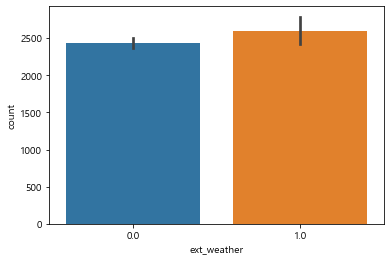

In [407]:
# ext_weather에 해당하는 경우 일평균 이용건수가 약간 높은 모습을 보임
plt.figure(figsize = (6,4))
sns.barplot(x = df_climate['ext_weather'], y = df_climate['count'])

<AxesSubplot:title={'center':'기상 변수와의 상관성 분석'}>

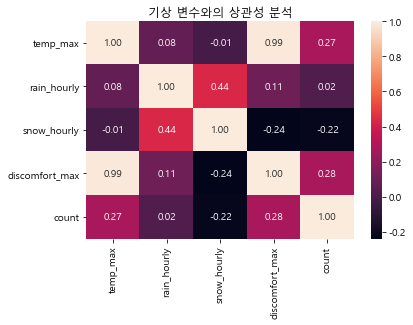

In [408]:
# count 변수와의 상관관계는 discomfort_max > temp_max > snow_hourly > rain_hourly 순
df_climate_heatmap = df_climate[['temp_max', 'rain_hourly', 'snow_hourly', 'discomfort_max', 'count']]

plt.figure(figsize=(6, 4))
plt.title('기상 변수와의 상관성 분석')
sns.heatmap(df_climate_heatmap.corr(), annot=True, fmt='.2f')

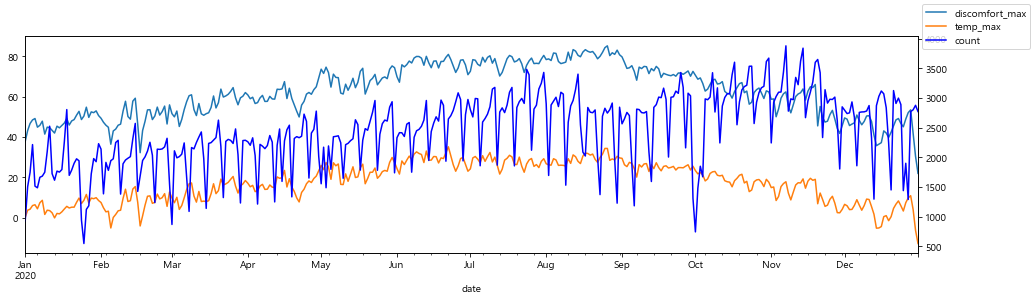

In [409]:
# 불쾌지수, 최고기온과 count 변수의 일자별 변화 시각화
ax = df_climate.plot(x="date", y=['discomfort_max', 'temp_max'], legend=False, figsize=(16,4))
ax2 = ax.twinx()
df_climate.plot(x="date", y="count", ax=ax2, legend=False, color="b")
ax.figure.legend()
plt.show()

In [410]:
df_climate

,date,count,temp_max,rain_sum,rain_count,snow_sum,snow_count,discomfort_max,rain_hourly,snow_hourly,ext_weather
0,2020-01-01,929,0.3,0.1,4,0.0,1,37.86114,0.0,0.0,0.0
1,2020-01-02,1507,3.8,0.0,0,0.0,0,43.26596,NaN,NaN,0.0
2,2020-01-03,1751,4.3,0.0,0,0.0,0,46.77010,NaN,NaN,0.0
3,2020-01-04,2217,6.1,0.0,0,0.0,0,48.51487,NaN,NaN,0.0
4,2020-01-05,1517,6.5,0.0,0,0.0,0,49.20550,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...
361,2020-12-27,1292,9.9,0.0,1,0.0,0,52.11449,0.0,NaN,0.0
362,2020-12-28,2773,11.0,1.3,2,0.0,0,53.50500,0.6,NaN,0.0
363,2020-12-29,2803,4.2,0.2,3,0.0,0,42.19692,0.1,NaN,0.0
364,2020-12-30,2879,-6.2,0.0,0,0.0,0,30.44586,NaN,NaN,1.0


In [411]:
# df 데이터셋에 기상 관련 변수 추가
df = df.merge(df_climate, how = 'outer', on = 'date').drop([
    'rain_sum','rain_count','snow_sum','snow_count','rain_hourly','snow_hourly','count_y'], axis = 1).rename(
    columns = {'count_x' : 'count'})
df

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1,join_yearmonth,pay_yearmonth,pay_dow,temp_max,discomfort_max,ext_weather
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN,2014-01,2020-01,Wednesday,0.3,37.86114,0.0
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J,2014-02,2020-01,Wednesday,0.3,37.86114,0.0
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC,2014-11,2020-01,Wednesday,0.3,37.86114,0.0
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP,2014-12,2020-01,Wednesday,0.3,37.86114,0.0
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR,2014-12,2020-01,Wednesday,0.3,37.86114,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878900,1830551,2020-12-31,BB,219886,B,2020-12-31,1,GN,2020-12,2020-12,Thursday,-12.7,22.03904,1.0
878901,1830570,2020-12-31,BB,82433,B,2020-12-31,1,CY,2020-12,2020-12,Thursday,-12.7,22.03904,1.0
878902,1830580,2020-12-31,AA,92020,B,2020-12-31,1,JRR,2020-12,2020-12,Thursday,-12.7,22.03904,1.0
878903,1830589,2020-12-31,BB,92437,B,2020-12-31,1,J,2020-12,2020-12,Thursday,-12.7,22.03904,1.0


## 교통량 데이터

In [412]:
# 기상정보 데이터셋 불러오기
traffic = pd.read_excel('2020교통량통합.xlsx')
traffic

,DATE,지점명,지점번호,방향,구분,0시,1시,2시,3시,4시,...,14시,15시,16시,17시,18시,19시,20시,21시,22시,23시
0,2020-01-01,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,712.0,645.0,437.0,309.0,290.0,...,1472.0,1416.0,1483.0,1329.0,1157.0,1014.0,954.0,849.0,780.0,480.0
1,2020-01-02,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,315.0,222.0,186.0,165.0,266.0,...,1792.0,1897.0,1842.0,2061.0,1994.0,1443.0,1233.0,1165.0,1094.0,852.0
2,2020-01-03,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,632.0,457.0,295.0,236.0,279.0,...,2004.0,1929.0,2049.0,2140.0,2178.0,1654.0,1356.0,1260.0,1253.0,941.0
3,2020-01-04,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,740.0,518.0,388.0,331.0,330.0,...,1837.0,1788.0,1588.0,1669.0,1530.0,1222.0,1143.0,1089.0,1039.0,791.0
4,2020-01-05,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,533.0,424.0,297.0,230.0,209.0,...,1634.0,1673.0,1494.0,1429.0,1288.0,1035.0,987.0,884.0,803.0,564.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98815,2020-12-27,서부간선도로,F-09,유출,목동교->신정교,1310.0,804.0,582.0,473.0,488.0,...,3026.0,2957.0,2799.0,2858.0,2805.0,3031.0,3173.0,2928.0,2278.0,1559.0
98816,2020-12-28,서부간선도로,F-09,유출,목동교->신정교,1030.0,614.0,501.0,565.0,1160.0,...,2925.0,2595.0,2705.0,2264.0,2272.0,2954.0,3081.0,3099.0,2521.0,1837.0
98817,2020-12-29,서부간선도로,F-09,유출,목동교->신정교,1294.0,833.0,582.0,597.0,900.0,...,2634.0,2851.0,2704.0,2163.0,2165.0,2738.0,3054.0,3078.0,2544.0,1952.0
98818,2020-12-30,서부간선도로,F-09,유출,목동교->신정교,1451.0,929.0,616.0,591.0,929.0,...,2901.0,2636.0,2175.0,2036.0,1969.0,2787.0,3058.0,2936.0,2730.0,2160.0


In [413]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98820 entries, 0 to 98819
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    98820 non-null  datetime64[ns]
 1   지점명     98820 non-null  object        
 2   지점번호    98820 non-null  object        
 3   방향      98820 non-null  object        
 4   구분      98820 non-null  object        
 5   0시      91985 non-null  float64       
 6   1시      91962 non-null  float64       
 7   2시      91960 non-null  float64       
 8   3시      91979 non-null  float64       
 9   4시      91999 non-null  float64       
 10  5시      92036 non-null  float64       
 11  6시      92079 non-null  float64       
 12  7시      92095 non-null  float64       
 13  8시      92081 non-null  float64       
 14  9시      92110 non-null  float64       
 15  10시     92144 non-null  float64       
 16  11시     92100 non-null  float64       
 17  12시     92067 non-null  float64       
 18  13시   

In [414]:
# 일별 교통량 합계 구하기
traffic['traffic_sum'] = traffic.loc[:,'0시':'23시'].sum(axis = 1)

In [415]:
traffic_grouped = traffic.groupby('DATE')['traffic_sum'].sum().reset_index().rename(columns = {'DATE' : 'date'})
df_traffic = traffic_grouped.merge(df_temp, how = 'outer', on = 'date')
df_traffic

,date,traffic_sum,count
0,2020-01-01,7347299.0,929
1,2020-01-02,9326734.0,1507
2,2020-01-03,9998638.0,1751
3,2020-01-04,9198233.0,2217
4,2020-01-05,7868358.0,1517
...,...,...,...
361,2020-12-27,5606406.0,1292
362,2020-12-28,8389535.0,2773
363,2020-12-29,8523717.0,2803
364,2020-12-30,8455563.0,2879


<AxesSubplot:title={'center':'교통량 변수와의 상관성 분석'}>

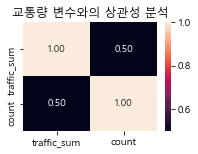

In [416]:
# 교통량과 count 변수와의 상관관계는 0.5로 높은편임
df_traffic_heatmap = df_traffic[['traffic_sum', 'count']]

plt.figure(figsize=(3, 2))
plt.title('교통량 변수와의 상관성 분석')
sns.heatmap(df_traffic_heatmap.corr(), annot=True, fmt='.2f')

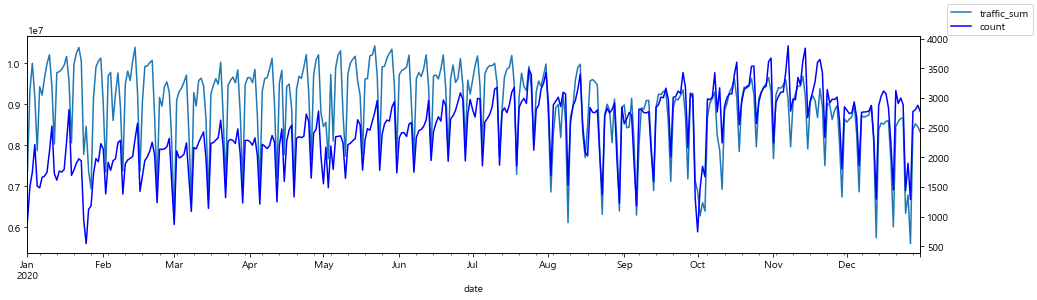

In [417]:
ax = df_traffic.plot(x="date", y='traffic_sum', legend=False, figsize=(16,4))
ax2 = ax.twinx()
df_traffic.plot(x="date", y="count", ax=ax2, legend=False, color="b")
ax.figure.legend()
plt.show()

In [418]:
# df 데이터셋에 교통량 변수 추가
df = df.merge(df_traffic, how = 'outer', on = 'date').drop('count_y', axis = 1).rename(columns = {'count_x' : 'count'})
df

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1,join_yearmonth,pay_yearmonth,pay_dow,temp_max,discomfort_max,ext_weather,traffic_sum
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN,2014-01,2020-01,Wednesday,0.3,37.86114,0.0,7347299.0
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J,2014-02,2020-01,Wednesday,0.3,37.86114,0.0,7347299.0
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC,2014-11,2020-01,Wednesday,0.3,37.86114,0.0,7347299.0
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP,2014-12,2020-01,Wednesday,0.3,37.86114,0.0,7347299.0
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR,2014-12,2020-01,Wednesday,0.3,37.86114,0.0,7347299.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878900,1830551,2020-12-31,BB,219886,B,2020-12-31,1,GN,2020-12,2020-12,Thursday,-12.7,22.03904,1.0,8324393.0
878901,1830570,2020-12-31,BB,82433,B,2020-12-31,1,CY,2020-12,2020-12,Thursday,-12.7,22.03904,1.0,8324393.0
878902,1830580,2020-12-31,AA,92020,B,2020-12-31,1,JRR,2020-12,2020-12,Thursday,-12.7,22.03904,1.0,8324393.0
878903,1830589,2020-12-31,BB,92437,B,2020-12-31,1,J,2020-12,2020-12,Thursday,-12.7,22.03904,1.0,8324393.0


⚡<b>인사이트</b>⚡
- 기온, 강수량, 적설량, 습도에 있어 극단적인 수치가 관측된 날이나 교통량이 많은 날에는 주차장소를 찾는데 시간을 많이 쏟지 않고 편리하게 주차하고자 하는 수요가 커질 것으로 가정
- 기상, 교통량 관련 변수중에는 교통량 변수가 count값과 가장 높은 상관관계를 보임
- temp_max(일최고기온), discomfort(불쾌지수), ext_weather(폭염, 폭우, 폭설, 불쾌지수 80% 이상이 있었던 날 표시), traffic(교통량) 컬럼 모델에 최종 사용

# 유저별 특징을 나타내는 컬럼 추가

In [419]:
# 유저, 날짜별 정렬
df_cum = df.sort_values(['user_id','date']).reset_index(drop=True)
df_cum.head()

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1,join_yearmonth,pay_yearmonth,pay_dow,temp_max,discomfort_max,ext_weather,traffic_sum
0,224,2013-12-16,AA,92510,A,2020-01-12,1,J,2013-12,2020-01,Sunday,2.5,43.35516,0.0,8033315.0
1,224,2013-12-16,AA,181833,C,2020-12-09,1,J,2013-12,2020-12,Wednesday,6.1,47.77138,0.0,8710203.0
2,232,2013-12-17,BB,109555,C,2020-01-19,1,GJ,2013-12,2020-01,Sunday,4.9,45.98688,0.0,8062593.0
3,232,2013-12-17,BB,28018,C,2020-01-26,1,JRR,2013-12,2020-01,Sunday,11.6,54.82304,0.0,7371640.0
4,232,2013-12-17,BB,28018,C,2020-01-27,1,JRR,2013-12,2020-01,Monday,7.4,49.78336,0.0,6941343.0


In [420]:
# 유저별 각 이용 시점 전의 누적 이용건수 cumsum 컬럼에 추가
df_cum['shifted'] = df_cum.groupby('user_id')['count'].shift()
df_cum['cumsum'] = df_cum.groupby('user_id')['shifted'].cumsum(axis = 0)
df_cum.loc[df_cum['cumsum'].isnull(), 'cumsum'] = 0
df_cum

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1,join_yearmonth,pay_yearmonth,pay_dow,temp_max,discomfort_max,ext_weather,traffic_sum,shifted,cumsum
0,224,2013-12-16,AA,92510,A,2020-01-12,1,J,2013-12,2020-01,Sunday,2.5,43.35516,0.0,8033315.0,NaN,0.0
1,224,2013-12-16,AA,181833,C,2020-12-09,1,J,2013-12,2020-12,Wednesday,6.1,47.77138,0.0,8710203.0,1.0,1.0
2,232,2013-12-17,BB,109555,C,2020-01-19,1,GJ,2013-12,2020-01,Sunday,4.9,45.98688,0.0,8062593.0,NaN,0.0
3,232,2013-12-17,BB,28018,C,2020-01-26,1,JRR,2013-12,2020-01,Sunday,11.6,54.82304,0.0,7371640.0,1.0,1.0
4,232,2013-12-17,BB,28018,C,2020-01-27,1,JRR,2013-12,2020-01,Monday,7.4,49.78336,0.0,6941343.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878900,1830551,2020-12-31,BB,219886,B,2020-12-31,1,GN,2020-12,2020-12,Thursday,-12.7,22.03904,1.0,8324393.0,NaN,0.0
878901,1830570,2020-12-31,BB,82433,B,2020-12-31,1,CY,2020-12,2020-12,Thursday,-12.7,22.03904,1.0,8324393.0,NaN,0.0
878902,1830580,2020-12-31,AA,92020,B,2020-12-31,1,JRR,2020-12,2020-12,Thursday,-12.7,22.03904,1.0,8324393.0,NaN,0.0
878903,1830589,2020-12-31,BB,92437,B,2020-12-31,1,J,2020-12,2020-12,Thursday,-12.7,22.03904,1.0,8324393.0,NaN,0.0


<AxesSubplot:>

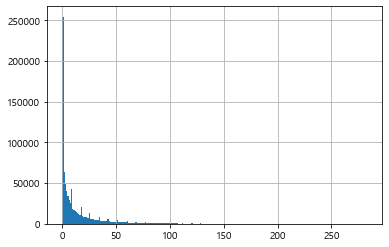

In [421]:
df_cum['cumsum'].hist(bins = 250)

In [422]:
# 누적 이용횟수에 따라 유저 회원등급 부여
# 모델에 컬럼 사용할 때는 각 유저마다 train set의 최종 회원등급을 test set의 데이터에 일괄적으로 부여해야 함

df_cum.loc[df_cum['cumsum'] == 0, 'user_lvl'] = 1    # 첫이용시 회원등급
df_cum.loc[df_cum['cumsum'] == 1, 'user_lvl'] = 2    # 두번째 이용시 회원등급
df_cum.loc[(df_cum['cumsum'] > 1) & (df_cum['cumsum'] <= 10), 'user_lvl'] = 3     # 누적이용 2~10회일 때 회원등급
df_cum.loc[(df_cum['cumsum'] > 10) & (df_cum['cumsum'] <= 50), 'user_lvl'] = 4    # 누적이용 11~50회일 때 회원등급
df_cum.loc[(df_cum['cumsum'] > 50) & (df_cum['cumsum'] <= 100), 'user_lvl'] = 5    # 누적이용 51~100회일 때 회원등급
df_cum.loc[df_cum['cumsum'] > 100, 'user_lvl'] = 6    # 누적이용 100회 이상일 때 회원등급
df_cum

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1,join_yearmonth,pay_yearmonth,pay_dow,temp_max,discomfort_max,ext_weather,traffic_sum,shifted,cumsum,user_lvl
0,224,2013-12-16,AA,92510,A,2020-01-12,1,J,2013-12,2020-01,Sunday,2.5,43.35516,0.0,8033315.0,NaN,0.0,1.0
1,224,2013-12-16,AA,181833,C,2020-12-09,1,J,2013-12,2020-12,Wednesday,6.1,47.77138,0.0,8710203.0,1.0,1.0,2.0
2,232,2013-12-17,BB,109555,C,2020-01-19,1,GJ,2013-12,2020-01,Sunday,4.9,45.98688,0.0,8062593.0,NaN,0.0,1.0
3,232,2013-12-17,BB,28018,C,2020-01-26,1,JRR,2013-12,2020-01,Sunday,11.6,54.82304,0.0,7371640.0,1.0,1.0,2.0
4,232,2013-12-17,BB,28018,C,2020-01-27,1,JRR,2013-12,2020-01,Monday,7.4,49.78336,0.0,6941343.0,1.0,2.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878900,1830551,2020-12-31,BB,219886,B,2020-12-31,1,GN,2020-12,2020-12,Thursday,-12.7,22.03904,1.0,8324393.0,NaN,0.0,1.0
878901,1830570,2020-12-31,BB,82433,B,2020-12-31,1,CY,2020-12,2020-12,Thursday,-12.7,22.03904,1.0,8324393.0,NaN,0.0,1.0
878902,1830580,2020-12-31,AA,92020,B,2020-12-31,1,JRR,2020-12,2020-12,Thursday,-12.7,22.03904,1.0,8324393.0,NaN,0.0,1.0
878903,1830589,2020-12-31,BB,92437,B,2020-12-31,1,J,2020-12,2020-12,Thursday,-12.7,22.03904,1.0,8324393.0,NaN,0.0,1.0


# 모델을 통한 예측 - by rows

## 1회만 결제한 유저

### 제외한 버전

In [ ]:
# # 사용 이력이 1회인 유저 onetime_user_list에 저장 
# onetime_user_list = df_user.loc[df_user['count']==1, 'user_id'].to_list()

In [ ]:
# df_model = df[~df['user_id'].isin(onetime_user_list)]
# df_model

### 제외하지 않은 버전

In [423]:
df_cum

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1,join_yearmonth,pay_yearmonth,pay_dow,temp_max,discomfort_max,ext_weather,traffic_sum,shifted,cumsum,user_lvl
0,224,2013-12-16,AA,92510,A,2020-01-12,1,J,2013-12,2020-01,Sunday,2.5,43.35516,0.0,8033315.0,NaN,0.0,1.0
1,224,2013-12-16,AA,181833,C,2020-12-09,1,J,2013-12,2020-12,Wednesday,6.1,47.77138,0.0,8710203.0,1.0,1.0,2.0
2,232,2013-12-17,BB,109555,C,2020-01-19,1,GJ,2013-12,2020-01,Sunday,4.9,45.98688,0.0,8062593.0,NaN,0.0,1.0
3,232,2013-12-17,BB,28018,C,2020-01-26,1,JRR,2013-12,2020-01,Sunday,11.6,54.82304,0.0,7371640.0,1.0,1.0,2.0
4,232,2013-12-17,BB,28018,C,2020-01-27,1,JRR,2013-12,2020-01,Monday,7.4,49.78336,0.0,6941343.0,1.0,2.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878900,1830551,2020-12-31,BB,219886,B,2020-12-31,1,GN,2020-12,2020-12,Thursday,-12.7,22.03904,1.0,8324393.0,NaN,0.0,1.0
878901,1830570,2020-12-31,BB,82433,B,2020-12-31,1,CY,2020-12,2020-12,Thursday,-12.7,22.03904,1.0,8324393.0,NaN,0.0,1.0
878902,1830580,2020-12-31,AA,92020,B,2020-12-31,1,JRR,2020-12,2020-12,Thursday,-12.7,22.03904,1.0,8324393.0,NaN,0.0,1.0
878903,1830589,2020-12-31,BB,92437,B,2020-12-31,1,J,2020-12,2020-12,Thursday,-12.7,22.03904,1.0,8324393.0,NaN,0.0,1.0


In [424]:
# df_model 데이터셋 만들고 모델 예측에 필요한 컬럼만 남기기
df_model = df_cum.copy()
df_model = df_model.drop(['join_date', 'store_id', 'join_yearmonth', 'pay_yearmonth', 'shifted', 'cumsum'], axis = 1)
df_model

,user_id,d_type,goods_type,date,count,ad1,pay_dow,temp_max,discomfort_max,ext_weather,traffic_sum,user_lvl
0,224,AA,A,2020-01-12,1,J,Sunday,2.5,43.35516,0.0,8033315.0,1.0
1,224,AA,C,2020-12-09,1,J,Wednesday,6.1,47.77138,0.0,8710203.0,2.0
2,232,BB,C,2020-01-19,1,GJ,Sunday,4.9,45.98688,0.0,8062593.0,1.0
3,232,BB,C,2020-01-26,1,JRR,Sunday,11.6,54.82304,0.0,7371640.0,2.0
4,232,BB,C,2020-01-27,1,JRR,Monday,7.4,49.78336,0.0,6941343.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
878900,1830551,BB,B,2020-12-31,1,GN,Thursday,-12.7,22.03904,1.0,8324393.0,1.0
878901,1830570,BB,B,2020-12-31,1,CY,Thursday,-12.7,22.03904,1.0,8324393.0,1.0
878902,1830580,AA,B,2020-12-31,1,JRR,Thursday,-12.7,22.03904,1.0,8324393.0,1.0
878903,1830589,BB,B,2020-12-31,1,J,Thursday,-12.7,22.03904,1.0,8324393.0,1.0


In [425]:
# 범주형 변수 컬럼 cat_columns로 구분
cat_columns = [c for c, t in zip(df_model.dtypes.index, df_model.dtypes) if t == 'O'] 
other_columns = [c for c in df_model.columns if c not in cat_columns]

print(f'Categorical Columns: \n{cat_columns}\n\n Other Columns: \n{other_columns}')

Categorical Columns: 
['d_type', 'goods_type', 'ad1', 'pay_dow']

 Other Columns: 
['user_id', 'date', 'count', 'temp_max', 'discomfort_max', 'ext_weather', 'traffic_sum', 'user_lvl']


## train, test set 나누기

In [426]:
# train set (2020-01 ~ 2020-09)
df_train = df_model[df_model['date'] <= '2020-09-30']
df_train

,user_id,d_type,goods_type,date,count,ad1,pay_dow,temp_max,discomfort_max,ext_weather,traffic_sum,user_lvl
0,224,AA,A,2020-01-12,1,J,Sunday,2.5,43.35516,0.0,8033315.0,1.0
2,232,BB,C,2020-01-19,1,GJ,Sunday,4.9,45.98688,0.0,8062593.0,1.0
3,232,BB,C,2020-01-26,1,JRR,Sunday,11.6,54.82304,0.0,7371640.0,2.0
4,232,BB,C,2020-01-27,1,JRR,Monday,7.4,49.78336,0.0,6941343.0,3.0
5,232,BB,A,2020-01-29,1,YO,Wednesday,9.5,52.11616,0.0,9906009.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
834786,1709914,BB,B,2020-09-30,1,GN,Wednesday,25.6,72.55800,0.0,7129682.0,1.0
834801,1709935,AA,B,2020-09-30,1,MP,Wednesday,25.6,72.55800,0.0,7129682.0,1.0
834802,1709942,AA,B,2020-09-30,1,BF,Wednesday,25.6,72.55800,0.0,7129682.0,1.0
834803,1709950,BB,A,2020-09-30,2,JRR,Wednesday,25.6,72.55800,0.0,7129682.0,1.0


In [427]:
# 유저별 train set의 최종 등급 user_lvl에 저장
user_lvl = df_train.groupby('user_id')['user_lvl'].max().reset_index()
user_lvl

,user_id,user_lvl
0,224,1.0
1,232,4.0
2,565,1.0
3,729,1.0
4,1448,2.0
...,...,...
130254,1709914,1.0
130255,1709935,1.0
130256,1709942,1.0
130257,1709950,1.0


In [428]:
# test set (2020-10 ~ 2020-12) 
df_test = df_model[df_model['date'] > '2020-09-30'].drop('user_lvl', axis = 1)
df_test

,user_id,d_type,goods_type,date,count,ad1,pay_dow,temp_max,discomfort_max,ext_weather,traffic_sum
1,224,AA,C,2020-12-09,1,J,Wednesday,6.1,47.77138,0.0,8710203.0
21,232,BB,B,2020-10-02,1,JRR,Friday,21.8,68.69130,0.0,6282435.0
22,232,BB,A,2020-10-27,1,J,Tuesday,19.0,64.30580,0.0,9303245.0
23,232,BB,A,2020-11-16,1,J,Monday,18.2,62.75228,0.0,9047418.0
24,232,BB,A,2020-11-18,1,J,Wednesday,18.6,64.53378,0.0,9093256.0
...,...,...,...,...,...,...,...,...,...,...,...
878900,1830551,BB,B,2020-12-31,1,GN,Thursday,-12.7,22.03904,1.0,8324393.0
878901,1830570,BB,B,2020-12-31,1,CY,Thursday,-12.7,22.03904,1.0,8324393.0
878902,1830580,AA,B,2020-12-31,1,JRR,Thursday,-12.7,22.03904,1.0,8324393.0
878903,1830589,BB,B,2020-12-31,1,J,Thursday,-12.7,22.03904,1.0,8324393.0


In [429]:
# 유저별 train set의 최종등급을 test set의 user_lvl에 업데이트
df_test = df_test.merge(user_lvl, how = 'left', on = 'user_id')
df_test.loc[df_test['user_lvl'].isnull(), 'user_lvl'] = 0
df_test

,user_id,d_type,goods_type,date,count,ad1,pay_dow,temp_max,discomfort_max,ext_weather,traffic_sum,user_lvl
0,224,AA,C,2020-12-09,1,J,Wednesday,6.1,47.77138,0.0,8710203.0,1.0
1,232,BB,B,2020-10-02,1,JRR,Friday,21.8,68.69130,0.0,6282435.0,4.0
2,232,BB,A,2020-10-27,1,J,Tuesday,19.0,64.30580,0.0,9303245.0,4.0
3,232,BB,A,2020-11-16,1,J,Monday,18.2,62.75228,0.0,9047418.0,4.0
4,232,BB,A,2020-11-18,1,J,Wednesday,18.6,64.53378,0.0,9093256.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
255595,1830551,BB,B,2020-12-31,1,GN,Thursday,-12.7,22.03904,1.0,8324393.0,0.0
255596,1830570,BB,B,2020-12-31,1,CY,Thursday,-12.7,22.03904,1.0,8324393.0,0.0
255597,1830580,AA,B,2020-12-31,1,JRR,Thursday,-12.7,22.03904,1.0,8324393.0,0.0
255598,1830589,BB,B,2020-12-31,1,J,Thursday,-12.7,22.03904,1.0,8324393.0,0.0


In [430]:
# 모델 예측에 불필요한 컬럼 지우기
x_train = df_train.drop(['count', 'date'], axis = 1)
x_test = df_test.drop(['count', 'date'], axis = 1)
y_train = df_train['count']
y_test = df_test['count']

## 전처리 함수

In [451]:
# 원핫인코딩 전처리함수 (참고용)
from sklearn.preprocessing import OneHotEncoder

def onehotencoding(x_train, x_test):
    tmp_x_train = x_train.copy()
    tmp_x_test  = x_test.copy()
    
    # reset index
    tmp_x_train = tmp_x_train.reset_index(drop=True)
    tmp_x_test  = tmp_x_test.reset_index(drop=True)
    
    # cat_columns 원핫인코딩
    ohe = OneHotEncoder(sparse=False)
    x_all = pd.concat([tmp_x_train[cat_columns], 
                       tmp_x_test[cat_columns]], axis=0)

    new_x_all = ohe.fit_transform(x_all)
    
    ohe_columns = []
    for cat in ohe.categories_:
        ohe_columns += cat.tolist()
    
    new_x_all = pd.DataFrame(new_x_all, columns=ohe_columns)

    new_x_train_cat = new_x_all.iloc[:tmp_x_train.shape[0], :]
    new_x_test_cat =  new_x_all.iloc[tmp_x_train.shape[0]:, :]

    new_x_train_cat = new_x_train_cat.reset_index(drop=True)
    new_x_test_cat  = new_x_test_cat.reset_index(drop=True)

    tmp_x_train = tmp_x_train.drop(columns=cat_columns)
    tmp_x_test  = tmp_x_test.drop(columns=cat_columns)

    tmp_x_train = pd.concat([tmp_x_train, new_x_train_cat], axis=1)
    tmp_x_test = pd.concat([tmp_x_test, new_x_test_cat], axis=1)
    
    return tmp_x_train, tmp_x_test

In [432]:
# 라벨인코딩 전처리함수
from sklearn.preprocessing import LabelEncoder

def labelencoding(x_train, x_test):
    tmp_x_train = x_train.copy()
    tmp_x_test  = x_test.copy()
    
    # reset index
    tmp_x_train = tmp_x_train.reset_index(drop=True)
    tmp_x_test  = tmp_x_test.reset_index(drop=True)

    # cat_columns 라벨인코딩
    le = LabelEncoder()
    x_all = pd.concat([tmp_x_train[cat_columns], tmp_x_test[cat_columns]], axis=0)
    new_x_all = x_all.apply(LabelEncoder().fit_transform)
    
    new_x_train_cat = new_x_all.iloc[:tmp_x_train.shape[0], :]
    new_x_test_cat =  new_x_all.iloc[tmp_x_train.shape[0]:, :]

    new_x_train_cat = new_x_train_cat.reset_index(drop=True)
    new_x_test_cat  = new_x_test_cat.reset_index(drop=True)

    tmp_x_train = tmp_x_train.drop(columns=cat_columns)
    tmp_x_test  = tmp_x_test.drop(columns=cat_columns)

    tmp_x_train = pd.concat([tmp_x_train, new_x_train_cat], axis=1)
    tmp_x_test = pd.concat([tmp_x_test, new_x_test_cat], axis=1)
    
    return tmp_x_train, tmp_x_test

In [433]:
# 범주형 변수 라벨인코딩 진행
x_train, x_test = labelencoding(x_train, x_test)

In [434]:
x_train

,user_id,temp_max,discomfort_max,ext_weather,traffic_sum,user_lvl,d_type,goods_type,ad1,pay_dow
0,224,2.5,43.35516,0.0,8033315.0,1.0,0,0,49,3
1,232,4.9,45.98688,0.0,8062593.0,1.0,1,2,37,3
2,232,11.6,54.82304,0.0,7371640.0,2.0,1,2,51,3
3,232,7.4,49.78336,0.0,6941343.0,3.0,1,2,51,1
4,232,9.5,52.11616,0.0,9906009.0,3.0,1,0,81,6
...,...,...,...,...,...,...,...,...,...,...
623300,1709914,25.6,72.55800,0.0,7129682.0,1.0,1,1,39,6
623301,1709935,25.6,72.55800,0.0,7129682.0,1.0,0,1,52,6
623302,1709942,25.6,72.55800,0.0,7129682.0,1.0,0,1,4,6
623303,1709950,25.6,72.55800,0.0,7129682.0,1.0,1,0,51,6


array([[<AxesSubplot:title={'center':'user_id'}>,
        <AxesSubplot:title={'center':'temp_max'}>,
        <AxesSubplot:title={'center':'discomfort_max'}>],
       [<AxesSubplot:title={'center':'ext_weather'}>,
        <AxesSubplot:title={'center':'traffic_sum'}>,
        <AxesSubplot:title={'center':'user_lvl'}>],
       [<AxesSubplot:title={'center':'d_type'}>,
        <AxesSubplot:title={'center':'goods_type'}>,
        <AxesSubplot:title={'center':'ad1'}>],
       [<AxesSubplot:title={'center':'pay_dow'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

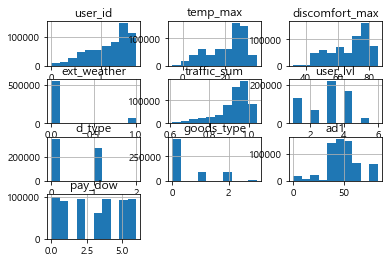

In [435]:
x_train.hist()

In [436]:
x_test

,user_id,temp_max,discomfort_max,ext_weather,traffic_sum,user_lvl,d_type,goods_type,ad1,pay_dow
0,224,6.1,47.77138,0.0,8710203.0,1.0,0,2,49,6
1,232,21.8,68.69130,0.0,6282435.0,4.0,1,1,51,0
2,232,19.0,64.30580,0.0,9303245.0,4.0,1,0,49,5
3,232,18.2,62.75228,0.0,9047418.0,4.0,1,0,49,1
4,232,18.6,64.53378,0.0,9093256.0,4.0,1,0,49,6
...,...,...,...,...,...,...,...,...,...,...
255595,1830551,-12.7,22.03904,1.0,8324393.0,0.0,1,1,39,4
255596,1830570,-12.7,22.03904,1.0,8324393.0,0.0,1,1,19,4
255597,1830580,-12.7,22.03904,1.0,8324393.0,0.0,0,1,51,4
255598,1830589,-12.7,22.03904,1.0,8324393.0,0.0,1,1,49,4


array([[<AxesSubplot:title={'center':'user_id'}>,
        <AxesSubplot:title={'center':'temp_max'}>,
        <AxesSubplot:title={'center':'discomfort_max'}>],
       [<AxesSubplot:title={'center':'ext_weather'}>,
        <AxesSubplot:title={'center':'traffic_sum'}>,
        <AxesSubplot:title={'center':'user_lvl'}>],
       [<AxesSubplot:title={'center':'d_type'}>,
        <AxesSubplot:title={'center':'goods_type'}>,
        <AxesSubplot:title={'center':'ad1'}>],
       [<AxesSubplot:title={'center':'pay_dow'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

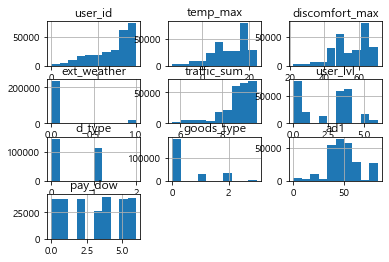

In [437]:
x_test.hist()

## 모델 생성 및 평가

In [440]:
# 트리계열 모델인 RandomForest, XGBoost, LightGBM 성능 비교
# MAE, MSE 기준 가장 좋은 성능을 내는 모델 : LightGBM

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

models = [['RandomForest', RandomForestRegressor()], 
          ['XGBoost', XGBRegressor(n_jobs=-1)], 
          ['LightGBM', LGBMRegressor(n_jobs=-1)]]

best_loss_mae = np.inf
best_loss_mse = np.inf

for i, (name, model) in enumerate(models):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    current_loss_mae = mean_absolute_error(y_test, y_pred)
    current_loss_mse = mean_squared_error(y_test, y_pred)
    
    if current_loss_mae < best_loss_mae:
        best_loss_mae  = current_loss_mae
        best_model_mae = [i, name, model]
    print(f'{name} Model Mean Absolute Error: {best_loss_mae}')
    
    if current_loss_mse < best_loss_mse:
        best_loss_mse  = current_loss_mse
        best_model_mse = [i, name, model]
    print(f'{name} Model Mean Squared Error: {best_loss_mse}')
    
print(f'Best Model (MAE기준): {best_model_mae[-2]}, MAE : {best_loss_mae}')
print(f'Best Model (MSE기준): {best_model_mse[-2]}, MSE : {best_loss_mse}')

RandomForest Model Mean Absolute Error: 0.17401165884194053
RandomForest Model Mean Squared Error: 0.11599671596244132
XGBoost Model Mean Absolute Error: 0.09835507211387624
XGBoost Model Mean Squared Error: 0.05892176677666481
LightGBM Model Mean Absolute Error: 0.06434247651031687
LightGBM Model Mean Squared Error: 0.045484087292266405
Best Model (MAE기준): LightGBM, MAE : 0.06434247651031687
Best Model (MSE기준): LightGBM, MSE : 0.045484087292266405


## 변수 중요도

In [441]:
# 최종 선택 모델의 변수 중요도 확인
best_model[-1].feature_importances_

array([883, 236, 267,   2, 323, 369, 151, 178, 491, 100])

In [442]:
pd.DataFrame(sorted(zip(best_model[-1].feature_importances_, x_train.columns), reverse=True), columns=['Value','Feature'])

,Value,Feature
0,883,user_id
1,491,ad1
2,369,user_lvl
3,323,traffic_sum
4,267,discomfort_max
5,236,temp_max
6,178,goods_type
7,151,d_type
8,100,pay_dow
9,2,ext_weather


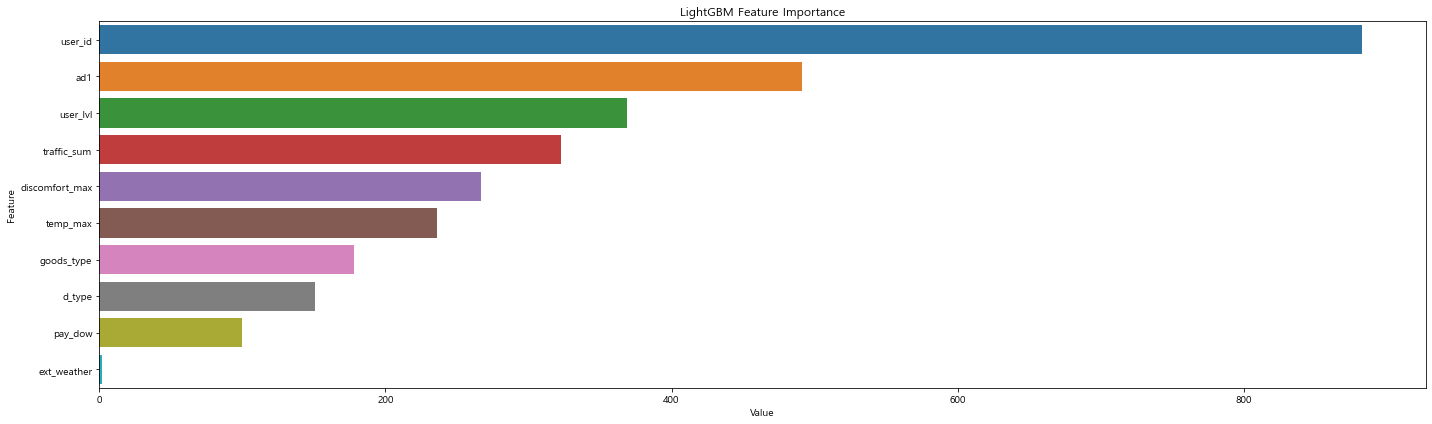

In [443]:
# Feature importance
feature_imp = pd.DataFrame(sorted(zip(best_model[-1].feature_importances_,x_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 6))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(20))
plt.title('LightGBM Feature Importance')
plt.tight_layout()
plt.show()

⚡<b>인사이트</b>⚡
- 이용건수 예측에 user_id가 가장 큰 변수중요도를 가지며, 이는 전체 데이터셋에 1회만 이용한 유저가 많아 나타난 결과인 것으로 판단됨
- ad1의 중요도가 높게 나온 것은 heavy user가 같은 지역의 store을 주로 이용하는 경향이 있기 때문일 것으로 보임

# (추가분석) 모델을 통한 예측 - by user_id & pay_yearmonth

## user_id & pay_yearmonth 기준으로 groupby한 데이터셋 생성

In [445]:
df_model['pay_yearmonth'] = df_model['date'].dt.strftime('%Y-%m')
df_model

,user_id,d_type,goods_type,date,count,ad1,pay_dow,temp_max,discomfort_max,ext_weather,traffic_sum,user_lvl,pay_yearmonth
0,224,AA,A,2020-01-12,1,J,Sunday,2.5,43.35516,0.0,8033315.0,1.0,2020-01
1,224,AA,C,2020-12-09,1,J,Wednesday,6.1,47.77138,0.0,8710203.0,2.0,2020-12
2,232,BB,C,2020-01-19,1,GJ,Sunday,4.9,45.98688,0.0,8062593.0,1.0,2020-01
3,232,BB,C,2020-01-26,1,JRR,Sunday,11.6,54.82304,0.0,7371640.0,2.0,2020-01
4,232,BB,C,2020-01-27,1,JRR,Monday,7.4,49.78336,0.0,6941343.0,3.0,2020-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
878900,1830551,BB,B,2020-12-31,1,GN,Thursday,-12.7,22.03904,1.0,8324393.0,1.0,2020-12
878901,1830570,BB,B,2020-12-31,1,CY,Thursday,-12.7,22.03904,1.0,8324393.0,1.0,2020-12
878902,1830580,AA,B,2020-12-31,1,JRR,Thursday,-12.7,22.03904,1.0,8324393.0,1.0,2020-12
878903,1830589,BB,B,2020-12-31,1,J,Thursday,-12.7,22.03904,1.0,8324393.0,1.0,2020-12


In [452]:
# 범주형 변수 컬럼 cat_columns로 구분
cat_columns = [c for c, t in zip(df_model.dtypes.index, df_model.dtypes) if t == 'O'] 
other_columns = [c for c in df_model.columns if c not in cat_columns]

print(f'Categorical Columns: \n{cat_columns}\n\n Other Columns: \n{other_columns}')

Categorical Columns: 
['d_type', 'goods_type', 'ad1', 'pay_dow', 'pay_yearmonth']

 Other Columns: 
['user_id', 'date', 'count', 'temp_max', 'discomfort_max', 'ext_weather', 'traffic_sum', 'user_lvl']


In [453]:
# 범주형 변수 원핫인코딩을 위해 pay_yearmonth 컬럼은 제외
cat_columns = ['d_type', 'goods_type', 'ad1', 'pay_dow']
cat_columns

['d_type', 'goods_type', 'ad1', 'pay_dow']

In [456]:
# train, test set 구분을 위해 date컬럼 datetime으로 변환
df_model['date'] = df_model['date'].apply(lambda x : pd.to_datetime(x))
df_model

,user_id,d_type,goods_type,date,count,ad1,pay_dow,temp_max,discomfort_max,ext_weather,traffic_sum,user_lvl,pay_yearmonth
0,224,AA,A,2020-01-12,1,J,Sunday,2.5,43.35516,0.0,8033315.0,1.0,2020-01
1,224,AA,C,2020-12-09,1,J,Wednesday,6.1,47.77138,0.0,8710203.0,2.0,2020-12
2,232,BB,C,2020-01-19,1,GJ,Sunday,4.9,45.98688,0.0,8062593.0,1.0,2020-01
3,232,BB,C,2020-01-26,1,JRR,Sunday,11.6,54.82304,0.0,7371640.0,2.0,2020-01
4,232,BB,C,2020-01-27,1,JRR,Monday,7.4,49.78336,0.0,6941343.0,3.0,2020-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
878900,1830551,BB,B,2020-12-31,1,GN,Thursday,-12.7,22.03904,1.0,8324393.0,1.0,2020-12
878901,1830570,BB,B,2020-12-31,1,CY,Thursday,-12.7,22.03904,1.0,8324393.0,1.0,2020-12
878902,1830580,AA,B,2020-12-31,1,JRR,Thursday,-12.7,22.03904,1.0,8324393.0,1.0,2020-12
878903,1830589,BB,B,2020-12-31,1,J,Thursday,-12.7,22.03904,1.0,8324393.0,1.0,2020-12


## train, test set 나누기

In [504]:
# train set (2020-01 ~ 2020-09)
df_train = df_model[df_model['date'] <= '2020-09-30']
df_train

,user_id,d_type,goods_type,date,count,ad1,pay_dow,temp_max,discomfort_max,ext_weather,traffic_sum,user_lvl,pay_yearmonth
0,224,AA,A,2020-01-12,1,J,Sunday,2.5,43.35516,0.0,8033315.0,1.0,2020-01
2,232,BB,C,2020-01-19,1,GJ,Sunday,4.9,45.98688,0.0,8062593.0,1.0,2020-01
3,232,BB,C,2020-01-26,1,JRR,Sunday,11.6,54.82304,0.0,7371640.0,2.0,2020-01
4,232,BB,C,2020-01-27,1,JRR,Monday,7.4,49.78336,0.0,6941343.0,3.0,2020-01
5,232,BB,A,2020-01-29,1,YO,Wednesday,9.5,52.11616,0.0,9906009.0,3.0,2020-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
834786,1709914,BB,B,2020-09-30,1,GN,Wednesday,25.6,72.55800,0.0,7129682.0,1.0,2020-09
834801,1709935,AA,B,2020-09-30,1,MP,Wednesday,25.6,72.55800,0.0,7129682.0,1.0,2020-09
834802,1709942,AA,B,2020-09-30,1,BF,Wednesday,25.6,72.55800,0.0,7129682.0,1.0,2020-09
834803,1709950,BB,A,2020-09-30,2,JRR,Wednesday,25.6,72.55800,0.0,7129682.0,1.0,2020-09


In [505]:
# test set (2020-10 ~ 2020-12) 
df_test = df_model[df_model['date'] > '2020-09-30'].drop('user_lvl', axis = 1)
df_test

,user_id,d_type,goods_type,date,count,ad1,pay_dow,temp_max,discomfort_max,ext_weather,traffic_sum,pay_yearmonth
1,224,AA,C,2020-12-09,1,J,Wednesday,6.1,47.77138,0.0,8710203.0,2020-12
21,232,BB,B,2020-10-02,1,JRR,Friday,21.8,68.69130,0.0,6282435.0,2020-10
22,232,BB,A,2020-10-27,1,J,Tuesday,19.0,64.30580,0.0,9303245.0,2020-10
23,232,BB,A,2020-11-16,1,J,Monday,18.2,62.75228,0.0,9047418.0,2020-11
24,232,BB,A,2020-11-18,1,J,Wednesday,18.6,64.53378,0.0,9093256.0,2020-11
...,...,...,...,...,...,...,...,...,...,...,...,...
878900,1830551,BB,B,2020-12-31,1,GN,Thursday,-12.7,22.03904,1.0,8324393.0,2020-12
878901,1830570,BB,B,2020-12-31,1,CY,Thursday,-12.7,22.03904,1.0,8324393.0,2020-12
878902,1830580,AA,B,2020-12-31,1,JRR,Thursday,-12.7,22.03904,1.0,8324393.0,2020-12
878903,1830589,BB,B,2020-12-31,1,J,Thursday,-12.7,22.03904,1.0,8324393.0,2020-12


In [506]:
# train set의 유저별 마지막 서비스 이용일
user_lastdate = df_train.groupby('user_id')['date'].max().reset_index()
user_lastdate

,user_id,date
0,224,2020-01-12
1,232,2020-08-26
2,565,2020-08-27
3,729,2020-09-05
4,1448,2020-06-01
...,...,...
130254,1709914,2020-09-30
130255,1709935,2020-09-30
130256,1709942,2020-09-30
130257,1709950,2020-09-30


In [507]:
# 유저별 train set의 최종 등급 user_lvl에 저장
user_lvl = user_lastdate.merge(df_train, on = ['user_id','date'], how = 'left').drop(['d_type', 'goods_type', 'count', 'ad1', 'pay_dow',
       'temp_max', 'discomfort_max', 'ext_weather', 'traffic_sum', 'pay_yearmonth'], axis = 1)
user_lvl

,user_id,date,user_lvl
0,224,2020-01-12,1.0
1,232,2020-08-26,4.0
2,565,2020-08-27,1.0
3,729,2020-09-05,1.0
4,1448,2020-06-01,2.0
...,...,...,...
130254,1709914,2020-09-30,1.0
130255,1709935,2020-09-30,1.0
130256,1709942,2020-09-30,1.0
130257,1709950,2020-09-30,1.0


In [513]:
# 유저별 train set의 최종등급을 test set의 user_lvl에 업데이트
df_test_lvl = df_test.merge(user_lvl, how = 'left', on = 'user_id').drop('date_y', axis=1).rename(columns = {'date_x' : 'date'})
df_test_lvl.loc[df_test_lvl['user_lvl'].isnull(), 'user_lvl'] = 0
df_test_lvl

,user_id,d_type,goods_type,date,count,ad1,pay_dow,temp_max,discomfort_max,ext_weather,traffic_sum,pay_yearmonth,user_lvl
0,224,AA,C,2020-12-09,1,J,Wednesday,6.1,47.77138,0.0,8710203.0,2020-12,1.0
1,232,BB,B,2020-10-02,1,JRR,Friday,21.8,68.69130,0.0,6282435.0,2020-10,4.0
2,232,BB,A,2020-10-27,1,J,Tuesday,19.0,64.30580,0.0,9303245.0,2020-10,4.0
3,232,BB,A,2020-11-16,1,J,Monday,18.2,62.75228,0.0,9047418.0,2020-11,4.0
4,232,BB,A,2020-11-18,1,J,Wednesday,18.6,64.53378,0.0,9093256.0,2020-11,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
255595,1830551,BB,B,2020-12-31,1,GN,Thursday,-12.7,22.03904,1.0,8324393.0,2020-12,0.0
255596,1830570,BB,B,2020-12-31,1,CY,Thursday,-12.7,22.03904,1.0,8324393.0,2020-12,0.0
255597,1830580,AA,B,2020-12-31,1,JRR,Thursday,-12.7,22.03904,1.0,8324393.0,2020-12,0.0
255598,1830589,BB,B,2020-12-31,1,J,Thursday,-12.7,22.03904,1.0,8324393.0,2020-12,0.0


In [526]:
df_test = df_test_lvl.copy()

In [527]:
# 범주형 변수 원핫인코딩 진행
x_train = df_train.copy()
x_test = df_test.copy()
x_train, x_test = onehotencoding(x_train, x_test)

In [528]:
x_train.head(2)

,user_id,date,count,temp_max,discomfort_max,ext_weather,traffic_sum,user_lvl,pay_yearmonth,AA,...,YO,ZE,ZP,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,224,2020-01-12,1,2.5,43.35516,0.0,8033315.0,1.0,2020-01,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,232,2020-01-19,1,4.9,45.98688,0.0,8062593.0,1.0,2020-01,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [529]:
x_test.head(2)

,user_id,date,count,temp_max,discomfort_max,ext_weather,traffic_sum,pay_yearmonth,user_lvl,AA,...,YO,ZE,ZP,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,224,2020-12-09,1,6.1,47.77138,0.0,8710203.0,2020-12,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,232,2020-10-02,1,21.8,68.69130,0.0,6282435.0,2020-10,4.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [530]:
agg_cols = ['ext_weather','count','AA', 'BB', 'CC', 'A',
       'B', 'C', 'D', '0', 'ABP', 'ADS', 'AOI', 'BF', 'BHW', 'BI', 'BJG',
       'BO', 'BOI', 'BP', 'BUD', 'CAS', 'CCA', 'CD', 'CN', 'COI', 'CU',
       'CVB', 'CY', 'DB', 'DIV', 'DJ', 'DM', 'DOI', 'DSO', 'EP', 'GAS',
       'GAY', 'GB', 'GBC', 'GD', 'GEJ', 'GGC', 'GGM', 'GGY', 'GHN', 'GJ',
       'GKP', 'GN', 'GPJ', 'GR', 'GS', 'GSN', 'GSW', 'GW', 'GYI', 'IND',
       'IYS', 'J', 'JR', 'JRR', 'MP', 'NO', 'NW', 'P', 'PJP', 'Q', 'QGI',
       'QH', 'R', 'RRR', 'SB', 'SC', 'SD', 'SDU', 'SG', 'SJV', 'SOD',
       'SOI', 'SP', 'VO', 'VU', 'WAE', 'WF', 'WH', 'WOID', 'WT', 'X',
       'YC', 'YD', 'YO', 'ZE', 'ZP', 'Friday', 'Monday', 'Saturday',
       'Sunday', 'Thursday', 'Tuesday', 'Wednesday']

In [531]:
# user_id, pay_yearmonth로 groupby하여 모델에 사용할 데이터셋 생성
# 기상, 교통량 관련 컬럼은 사용하지 않음
x_train_sum = x_train.groupby(['user_id', 'pay_yearmonth'])[agg_cols].agg('sum').reset_index()
x_train_sum

,user_id,pay_yearmonth,ext_weather,count,AA,BB,CC,A,B,C,...,YO,ZE,ZP,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,224,2020-01,0.0,1,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,232,2020-01,0.0,4,0.0,4.0,0.0,1.0,0.0,3.0,...,1.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0
2,232,2020-02,0.0,2,0.0,2.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,232,2020-03,0.0,2,0.0,2.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
4,232,2020-04,0.0,4,0.0,3.0,0.0,1.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267262,1709914,2020-09,0.0,1,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
267263,1709935,2020-09,0.0,1,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
267264,1709942,2020-09,0.0,1,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
267265,1709950,2020-09,0.0,2,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [532]:
x_train_max = x_train.groupby(['user_id', 'pay_yearmonth'])['user_lvl'].agg('max').reset_index()
x_train_max

,user_id,pay_yearmonth,user_lvl
0,224,2020-01,1.0
1,232,2020-01,3.0
2,232,2020-02,3.0
3,232,2020-03,3.0
4,232,2020-04,4.0
...,...,...,...
267262,1709914,2020-09,1.0
267263,1709935,2020-09,1.0
267264,1709942,2020-09,1.0
267265,1709950,2020-09,1.0


In [533]:
x_train = x_train_sum.merge(x_train_max, on = ['user_id', 'pay_yearmonth'], how = 'inner')
x_train

,user_id,pay_yearmonth,ext_weather,count,AA,BB,CC,A,B,C,...,ZE,ZP,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,user_lvl
0,224,2020-01,0.0,1,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,232,2020-01,0.0,4,0.0,4.0,0.0,1.0,0.0,3.0,...,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,3.0
2,232,2020-02,0.0,2,0.0,2.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,3.0
3,232,2020-03,0.0,2,0.0,2.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,3.0
4,232,2020-04,0.0,4,0.0,3.0,0.0,1.0,0.0,2.0,...,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267262,1709914,2020-09,0.0,1,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
267263,1709935,2020-09,0.0,1,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
267264,1709942,2020-09,0.0,1,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
267265,1709950,2020-09,0.0,2,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [534]:
# user_id, pay_yearmonth로 groupby하여 모델에 사용할 데이터셋 생성
# 기상, 교통량 관련 컬럼은 사용하지 않음
x_test_sum = x_test.groupby(['user_id', 'pay_yearmonth'])[agg_cols].agg('sum').reset_index()
x_test_sum

,user_id,pay_yearmonth,ext_weather,count,AA,BB,CC,A,B,C,...,YO,ZE,ZP,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,224,2020-12,0.0,1,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,232,2020-10,0.0,2,0.0,2.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,232,2020-11,0.0,2,0.0,2.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,342,2020-10,0.0,1,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,565,2020-11,0.0,1,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108145,1830551,2020-12,1.0,1,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
108146,1830570,2020-12,1.0,1,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
108147,1830580,2020-12,1.0,1,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
108148,1830589,2020-12,1.0,1,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [535]:
x_test_max = x_test.groupby(['user_id', 'pay_yearmonth'])['user_lvl'].agg('max').reset_index()
x_test_max

,user_id,pay_yearmonth,user_lvl
0,224,2020-12,1.0
1,232,2020-10,4.0
2,232,2020-11,4.0
3,342,2020-10,0.0
4,565,2020-11,1.0
...,...,...,...
108145,1830551,2020-12,0.0
108146,1830570,2020-12,0.0
108147,1830580,2020-12,0.0
108148,1830589,2020-12,0.0


In [536]:
x_test = x_test_sum.merge(x_test_max, on = ['user_id', 'pay_yearmonth'], how = 'inner')
x_test

,user_id,pay_yearmonth,ext_weather,count,AA,BB,CC,A,B,C,...,ZE,ZP,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,user_lvl
0,224,2020-12,0.0,1,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,232,2020-10,0.0,2,0.0,2.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0
2,232,2020-11,0.0,2,0.0,2.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,4.0
3,342,2020-10,0.0,1,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,565,2020-11,0.0,1,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108145,1830551,2020-12,1.0,1,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
108146,1830570,2020-12,1.0,1,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
108147,1830580,2020-12,1.0,1,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
108148,1830589,2020-12,1.0,1,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [539]:
# 목표변수 별도의 컬럼에 저장
y_train = x_train['count']
y_test = x_test['count']

In [541]:
# 모델 예측에 불필요한 컬럼 지우기
x_train = x_train.drop(['pay_yearmonth', 'count'], axis = 1)
x_test = x_test.drop(['pay_yearmonth', 'count'], axis = 1)

## 모델 생성 및 평가

In [542]:
# 트리계열 모델인 RandomForest, XGBoost, LightGBM 성능 비교
# MAE, MSE 기준 가장 좋은 성능을 내는 모델 : LightGBM

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

models = [['RandomForest', RandomForestRegressor()], 
          ['XGBoost', XGBRegressor(n_jobs=-1)], 
          ['LightGBM', LGBMRegressor(n_jobs=-1)]]

best_loss_mae = np.inf
best_loss_mse = np.inf

for i, (name, model) in enumerate(models):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    current_loss_mae = mean_absolute_error(y_test, y_pred)
    current_loss_mse = mean_squared_error(y_test, y_pred)
    
    if current_loss_mae < best_loss_mae:
        best_loss_mae  = current_loss_mae
        best_model_mae = [i, name, model]
    print(f'{name} Model Mean Absolute Error: {best_loss_mae}')
    
    if current_loss_mse < best_loss_mse:
        best_loss_mse  = current_loss_mse
        best_model_mse = [i, name, model]
    print(f'{name} Model Mean Squared Error: {best_loss_mse}')
    
print(f'Best Model (MAE기준): {best_model_mae[-2]}, MAE : {best_loss_mae}')
print(f'Best Model (MSE기준): {best_model_mse[-2]}, MSE : {best_loss_mse}')

RandomForest Model Mean Absolute Error: 0.18499584546008263
RandomForest Model Mean Squared Error: 0.6434683895409207
XGBoost Model Mean Absolute Error: 0.18379909939695385
XGBoost Model Mean Squared Error: 0.5393194532695982
LightGBM Model Mean Absolute Error: 0.10162733904722011
LightGBM Model Mean Squared Error: 0.32797550490028926
Best Model (MAE기준): LightGBM, MAE : 0.10162733904722011
Best Model (MSE기준): LightGBM, MSE : 0.32797550490028926


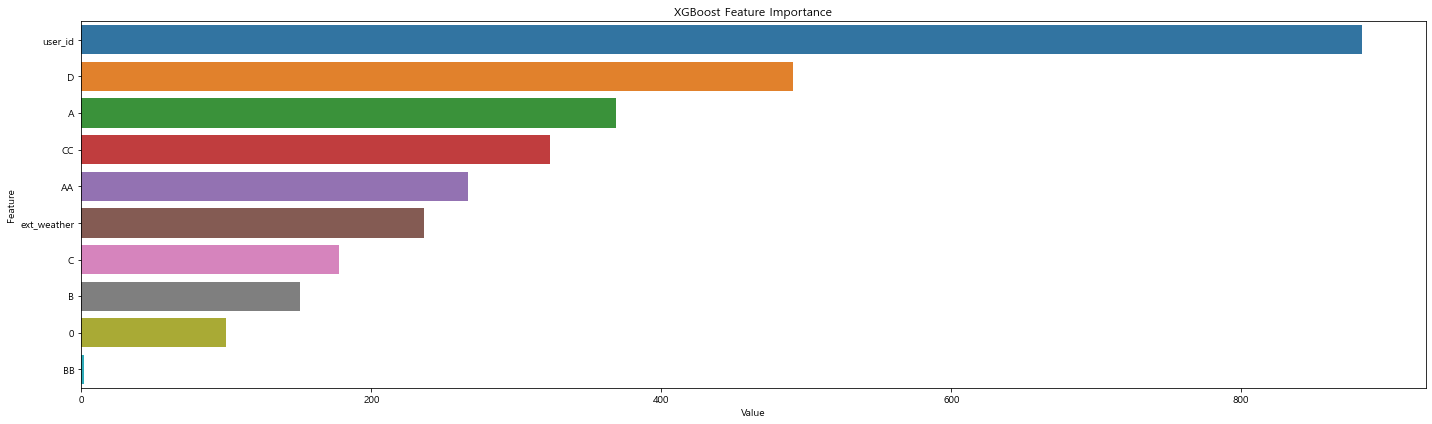

In [543]:
# Feature importance
feature_imp = pd.DataFrame(sorted(zip(best_model[-1].feature_importances_,x_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 6))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(20))
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()

⚡<b>인사이트</b>⚡
- user_id, pay_yearmonth로 groupby한 데이터셋으로 유저별, 월별 이용건수를 예측하였을 때는 XGBoost가 가장 좋은 성능을 보임
- user_id가 압도적으로 높은 feature importance를 보여 유저별 특성 파악 및 이를 활용한 프로모션 전략이 유효할 것으로 예상됨

# 결론
## 분석 한계점
- 전체 유저 중 서비스를 1회만 이용한 유저의 비중이 약 44.7%로, 서비스를 여러번 이용한 유저의 데이터가 더 축적되면 향후 이용건수 예측 정확도를 보다 높일 수 있을 것으로 보임<br>
- 서비스 이용시간에 대한 정보(date 컬럼), store의 구체적인 주소에 대한 정보(ad1 컬럼)가 있었다면 기상, 교통량 정보를 보다 정확하게 활용할 수 있을 것으로 보임

## 제안 방안
<b>유저별 특성을 반영한 프로모션</b>
- 잠수 유저는 평일 할인권, 비활성유저는 금토일 할인권 제공 
- 신규유저(브론즈 등급)에게는 금토일 할인권 제공, 오래된 유저일수록 평일 할인권 제공 

<b>기상, 교통량 조건을 반영한 프로모션</b>
- 폭염, 폭우, 폭설이 있거나 불쾌지수가 높을 것으로 예상되는 날 할인권 제공
- 교통량이 높을 것으로 예상되는 날 할인권 제공